#**Dimensionality Reduction - Bitcoin Price Prediction Problem**
**Chapter 7 Case Study 3**

#Problem Definition

the problem is about designing a bitcoin trading strategy by performing a classification task where the predicted target has a value 1 for buy and 0 for sell. Specifically, the target is labeled as 1 if the short-term price is expected to increase compared to the long term, and 0 otherwise. This project is also aimed to improve Case Study 3 in Chapter 7 from the book "Machine Learning & Data Science Blueprints for Finance" by applying different feature engineering, pipeline setup, different machine learning model, hyperparameter optimization, and more comprehensive evaluation metrics. The data is taken from Kaggle (https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd?select=BTC-Hourly.csv).

#0. Part 0 - Original method demonstration (with small modification)

*It is modified from:https://github.com/tatsath/fin-ml/blob/bc10f73984d23e1e968b63c4066228d603ca02fb/Chapter%207%20-%20Unsup.%20Learning%20-%20Dimensionality%20Reduction/CaseStudy3%20-Bitcoin%20Trading%20-%20Enhancing%20Speed%20and%20accuracy/BitcoinTradingEnhancingSpeedAccuracy.ipynb*

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3

from scipy.linalg import svd
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# from IPython.html.widgets import interactive, fixed

In [ ]:
# url = 'https://raw.githubusercontent.com/tatsath/fin-ml/bc10f73984d23e1e968b63c4066228d603ca02fb/Chapter%206%20-%20Sup.%20Learning%20-%20Classification%20models/CaseStudy3%20-%20Bitcoin%20Trading%20Strategy/BitstampData_sample.csv'
# dataset = pd.read_csv(url)

In [ ]:
# data taken from https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd?select=BTC-Hourly.csv

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#load BTC-Hourly.csv.zip
from google.colab import files
uploaded = files.upload()

Saving BTC-Hourly.csv.zip to BTC-Hourly.csv.zip


In [ ]:
import zipfile

# Unzip
with zipfile.ZipFile('BTC-Hourly.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
dataset = pd.read_csv('BTC-Hourly.csv')

In [ ]:
# shape
dataset.shape

(33259, 9)

In [ ]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
33254,1526378400,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,1.110e+07,1260.69
33255,1526374800,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1.594e+06,182.62
33256,1526371200,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7.986e+06,917.79
33257,1526367600,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2.390e+06,273.58
33258,1526364000,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4.907e+06,559.93


In [ ]:
# df = dataset.copy()

# # Convert 'timestamp' column to datetime data type
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# # Define the start and end dates for filtering
# start_date = '2020-01-01'
# end_date = '2023-12-31'

# # Filter the DataFrame to include only rows within the desired date range
# filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

In [ ]:
# filtered_df.tail(5)

In [ ]:
# df2 = dataset.copy()
# # Convert 'timestamp' column to datetime data type
# df2['timestamp'] = pd.to_datetime(df2['timestamp'])

# # Filter the DataFrame to keep only the data points with timestamps at midnight (00:00:00)
# df2 = df2[df2['timestamp'].dt.time == pd.Timestamp('00:00:00').time()]

In [ ]:
# df2.shape

In [ ]:
# df2.tail(5)

In [ ]:
# # Save the DataFrame to a CSV file
# filtered_df.to_csv('bitcoin_2020_to_2023.csv', index=False)

In [ ]:
dataset = dataset.drop(columns=['unix','date','symbol'])

In [ ]:
# describe data
set_option('display.precision', 3)
dataset.describe()

,open,high,low,close,Volume BTC,Volume USD
count,33259.000,33259.000,33259.000,33259.000,3.326e+04,3.326e+04
mean,20119.547,20232.957,19997.070,20120.685,1.612e+06,2.966e+06
std,18537.220,18646.951,18418.320,18537.695,3.102e+06,7.330e+06
min,3139.760,3158.340,3122.280,3139.760,0.000e+00,0.000e+00
25%,7022.865,7055.835,6970.570,7022.865,1.903e+02,1.683e+02
50%,9700.040,9740.270,9657.000,9700.320,6.093e+05,5.248e+02
75%,36415.305,36735.380,36104.235,36423.040,1.929e+06,3.120e+06
max,68635.050,69000.000,68447.000,68627.010,6.857e+07,2.582e+08


In [ ]:
#Checking for any null values and removing the null values
print('Null Values =',dataset.isnull().values.any())

Null Values = False




We attach a label to each movement:

* 1 if the signal is that short term price will go up as compared to the long term.
* 0 if the signal is that short term price will go down as compared to the long term.

We trade with open price.

In [ ]:
#Since we are trading right after the open,
#we only know yesterday's  high low close volume etc.
dataset['high'] = dataset['high'].shift(1).fillna(0)
dataset['low'] = dataset['low'].shift(1).fillna(0)
dataset['close'] = dataset['close'].shift(1).fillna(0)
dataset['Volume BTC'] = dataset['Volume BTC'].shift(1).fillna(0)
dataset['Volume USD'] = dataset['Volume USD'].shift(1).fillna(0)

In [ ]:
dataset.head()

,open,high,low,close,Volume BTC,Volume USD
0,43221.71,0.00,0.00,0.00,0.000,0.000e+00
1,43085.30,43626.49,43185.48,43312.27,52.056,2.255e+06
2,41657.23,43364.81,42892.37,43178.98,106.816,4.612e+06
3,41917.09,44256.08,41650.29,42907.32,527.541,2.264e+07
4,41361.99,41917.09,41542.60,41659.53,69.752,2.906e+06


In [ ]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['open'].pct_change(periods=10).shift(-1).fillna(0)

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['open'].pct_change(periods=60).shift(-1).fillna(0)

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [ ]:
dataset.head()

,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal
0,43221.71,0.00,0.00,0.00,0.000,0.000e+00,0.0,0.0,0.0
1,43085.30,43626.49,43185.48,43312.27,52.056,2.255e+06,0.0,0.0,0.0
2,41657.23,43364.81,42892.37,43178.98,106.816,4.612e+06,0.0,0.0,0.0
3,41917.09,44256.08,41650.29,42907.32,527.541,2.264e+07,0.0,0.0,0.0
4,41361.99,41917.09,41542.60,41659.53,69.752,2.906e+06,0.0,0.0,0.0




We perform feature engineering to construct technical indicators which will be used to make the predictions, and the output variable.

The current data of the bicoin consists of date, open, high, low, close and volume. Using this data we calculate the following technical indicators:

* Moving Average : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
* Stochastic Oscillator %K and %D : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* Relative Strength Index(RSI) :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
* Rate Of Change(ROC): It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
* Momentum (MOM) : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.



In [ ]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['close'], 10)
dataset['ROC30'] = ROC(dataset['close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['close'], 10)
dataset['MOM30'] = MOM(dataset['close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['close'], 10)
dataset['RSI30'] = RSI(dataset['close'], 30)
dataset['RSI200'] = RSI(dataset['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['close'], dataset['low'], dataset['high'], 10)
dataset['%D10'] = STOD(dataset['close'], dataset['low'], dataset['high'], 10)
dataset['%K30'] = STOK(dataset['close'], dataset['low'], dataset['high'], 30)
dataset['%D30'] = STOD(dataset['close'], dataset['low'], dataset['high'], 30)
dataset['%K200'] = STOK(dataset['close'], dataset['low'], dataset['high'], 200)
dataset['%D200'] = STOD(dataset['close'], dataset['low'], dataset['high'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
33254,8708.32,8821.19,8740.54,8760.00,2.843e+06,324.11,0.024,0.064,0.0,8611.609,...,56.258,85.472,90.870,91.515,94.744,95.584,97.290,8599.322,8398.227,8254.330
33255,8728.49,8865.00,8695.11,8795.90,1.110e+07,1260.69,0.023,0.069,0.0,8645.116,...,56.497,85.140,86.976,90.967,92.319,95.166,95.973,8627.702,8415.644,8260.833
33256,8739.00,8754.40,8701.35,8708.32,1.594e+06,182.62,0.024,0.070,0.0,8656.608,...,55.751,66.305,78.972,79.519,87.334,88.052,92.934,8642.974,8429.728,8266.794
33257,8740.99,8750.27,8660.53,8728.49,7.986e+06,917.79,0.025,0.058,0.0,8669.677,...,55.886,65.665,72.370,82.155,84.214,88.516,90.578,8663.158,8446.511,8272.309
33258,8733.86,8766.00,8721.11,8739.00,2.390e+06,273.58,0.000,0.000,0.0,8682.282,...,55.956,68.308,66.759,83.529,81.734,88.158,88.242,8682.424,8465.144,8277.454


In [ ]:
# # Calculation of exponential moving average
# def EMA(df, n):
#     EMA = pd.Series(df['open'].shift(-1).fillna(0).ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
#     return EMA

# dataset['EMA10'] = EMA(dataset, 10)
# dataset['EMA30'] = EMA(dataset, 30)
# dataset['EMA200'] = EMA(dataset, 200)

# # Calculation of rate of change
# def ROC(df, n):
#     M = df.shift(-1).fillna(0).diff(n - 1)
#     N = df.shift(-1).fillna(0).shift(n - 1)
#     ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
#     return ROC

# dataset['ROC10'] = ROC(dataset['open'], 10)
# dataset['ROC30'] = ROC(dataset['open'], 30)

# # Calculation of price momentum
# def MOM(df, n):
#     MOM = pd.Series(df.shift(-1).fillna(0).diff(n), name='Momentum_' + str(n))
#     return MOM

# dataset['MOM10'] = MOM(dataset['open'], 10)
# dataset['MOM30'] = MOM(dataset['open'], 30)

# # Calculation of relative strength index
# def RSI(series, period):
#     delta = series.shift(-1).fillna(0).diff().dropna()
#     u = delta * 0
#     d = u.copy()
#     u[delta > 0] = delta[delta > 0]
#     d[delta < 0] = -delta[delta < 0]
#     u[u.index[period-1]] = np.mean(u[:period])  # First value is sum of avg gains
#     u = u.drop(u.index[:(period-1)])
#     d[d.index[period-1]] = np.mean(d[:period])  # First value is sum of avg losses
#     d = d.drop(d.index[:(period-1)])
#     rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
#     return 100 - 100 / (1 + rs)

# dataset['RSI10'] = RSI(dataset['open'], 10)
# dataset['RSI30'] = RSI(dataset['open'], 30)
# dataset['RSI200'] = RSI(dataset['open'], 200)

# # Calculation of stochastic oscillator
# def STOK(open, low, high, n):
#     STOK = ((open.shift(-1).fillna(0) - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
#     return STOK

# def STOD(open, low, high, n):
#     STOK = ((open.shift(-1).fillna(0) - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
#     STOD = STOK.rolling(3).mean()
#     return STOD

# dataset['%K10'] = STOK(dataset['open'], dataset['low'], dataset['high'], 10)
# dataset['%D10'] = STOD(dataset['open'], dataset['low'], dataset['high'], 10)
# dataset['%K30'] = STOK(dataset['open'], dataset['low'], dataset['high'], 30)
# dataset['%D30'] = STOD(dataset['open'], dataset['low'], dataset['high'], 30)
# dataset['%K200'] = STOK(dataset['open'], dataset['low'], dataset['high'], 200)
# dataset['%D200'] = STOD(dataset['open'], dataset['low'], dataset['high'], 200)

# # Calculation of moving average
# def MA(df, n):
#     MA = pd.Series(df['open'].shift(-1).fillna(0).rolling(n, min_periods=n).mean(), name='MA_' + str(n))
#     return MA

# dataset['MA21'] = MA(dataset, 10)
# dataset['MA63'] = MA(dataset, 30)
# dataset['MA252'] = MA(dataset, 200)
# dataset.tail()

In [ ]:
#excluding columns that are not needed for our prediction.

dataset = dataset.drop(['high','low','close', 'Volume USD','short_mavg','long_mavg'], axis=1)

In [ ]:
dataset.tail()

,open,Volume BTC,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
33254,8708.32,2.843e+06,0.0,8611.609,8456.968,8179.580,2.912,5.881,267.72,462.60,...,56.258,85.472,90.870,91.515,94.744,95.584,97.290,8599.322,8398.227,8254.330
33255,8728.49,1.110e+07,0.0,8645.116,8478.834,8185.712,2.809,6.156,283.80,522.50,...,56.497,85.140,86.976,90.967,92.319,95.166,95.973,8627.702,8415.644,8260.833
33256,8739.00,1.594e+06,0.0,8656.608,8493.640,8190.912,2.131,5.876,152.72,422.52,...,55.751,66.305,78.972,79.519,87.334,88.052,92.934,8642.974,8429.728,8266.794
33257,8740.99,7.986e+06,0.0,8669.677,8508.792,8196.261,2.131,6.705,201.84,503.49,...,55.886,65.665,72.370,82.155,84.214,88.516,90.578,8663.158,8446.511,8272.309
33258,8733.86,2.390e+06,0.0,8682.282,8523.644,8201.662,2.387,4.470,192.66,559.01,...,55.956,68.308,66.759,83.529,81.734,88.158,88.242,8682.424,8465.144,8277.454


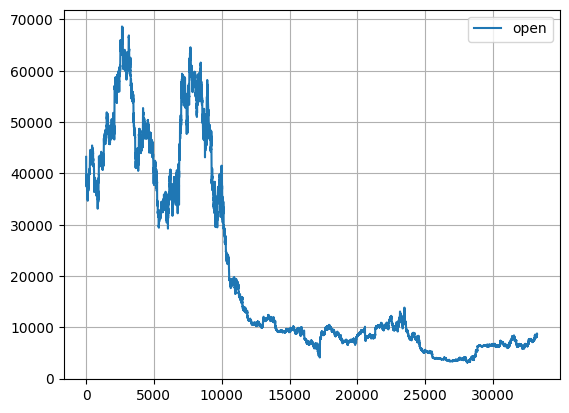

In [ ]:
dataset[['open']].plot(grid=True)
plt.show()

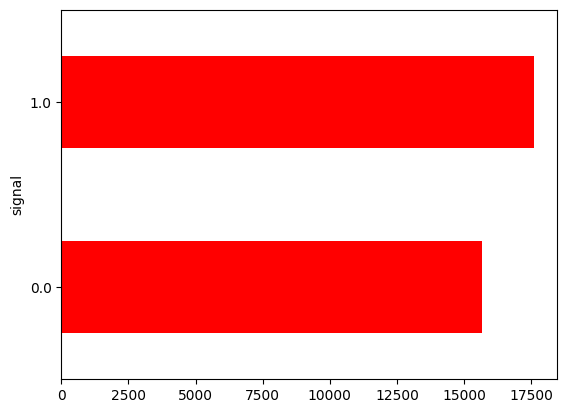

In [ ]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

We split the dataset into 80% training set and 20% test set.

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-10000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

As a preprocessing step, let's start with normalizing the feature values so they standardised - this makes comparisons simpler and allows next steps for Singular Value Decomposition.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,open,Volume BTC,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
25953,-1.094,-0.694,-1.080,-1.063,-1.039,-0.442,-0.555,-0.215,-0.287,-1.417,...,-1.282,-1.153,-1.039,-1.435,-1.360,-1.312,-1.214,-1.083,-1.054,-1.035
28399,-1.128,-0.283,-1.114,-1.106,-1.225,0.227,-0.426,0.155,-0.212,-0.317,...,0.709,0.254,0.075,-0.510,-0.624,0.882,0.856,-1.118,-1.088,-1.250


We want to reduce the dimensionality of the problem to make it more manageable, but at the same time we want to preserve as much information as possible.

Hence, we use a technique called singular value decomposition (SVD), which is one of the ways of performing PCA.Singular Value Decomposition (SVD) is a matrix factorization commonly used in signal processing and data compression. We are using the TruncatedSVD method in the sklearn package.


Variance preserved by first 5 components == 91.08%


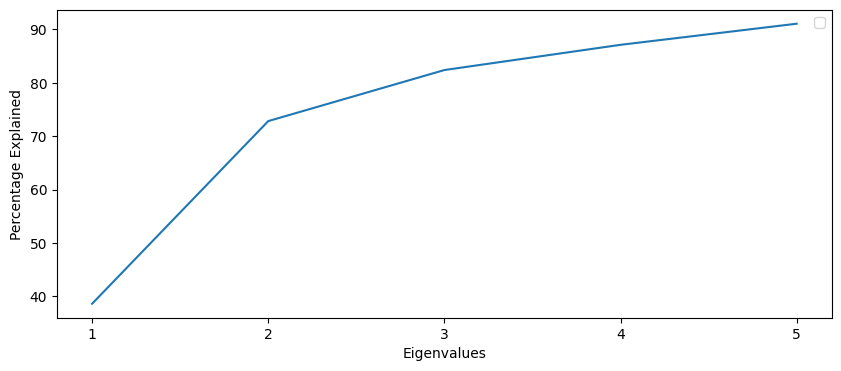

In [ ]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

We can preserve approximately 91% variance by using just 5 components rather than the full 25+ original features.

In [ ]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(26448, 5)


,c0,c1,c2,c3,c4
date,,,,,
2018-10-18 20:00:00,-2.525011,-0.515839,0.770773,0.999078,-0.984725
2021-07-10 00:00:00,2.437631,1.018301,-1.221824,0.696742,-1.169088
2020-08-25 21:00:00,-1.671692,-1.371356,-0.493289,-0.145376,-0.127201
2018-10-26 11:00:00,-2.273366,1.567795,-1.402177,2.021837,0.642279
2018-07-18 14:00:00,-2.454989,0.908862,0.378016,-0.174373,-0.061485


Lets attempt to visualise the data with the compressed dataset, represented by the top 5 components of an SVD.

In [ ]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (or type of signal).

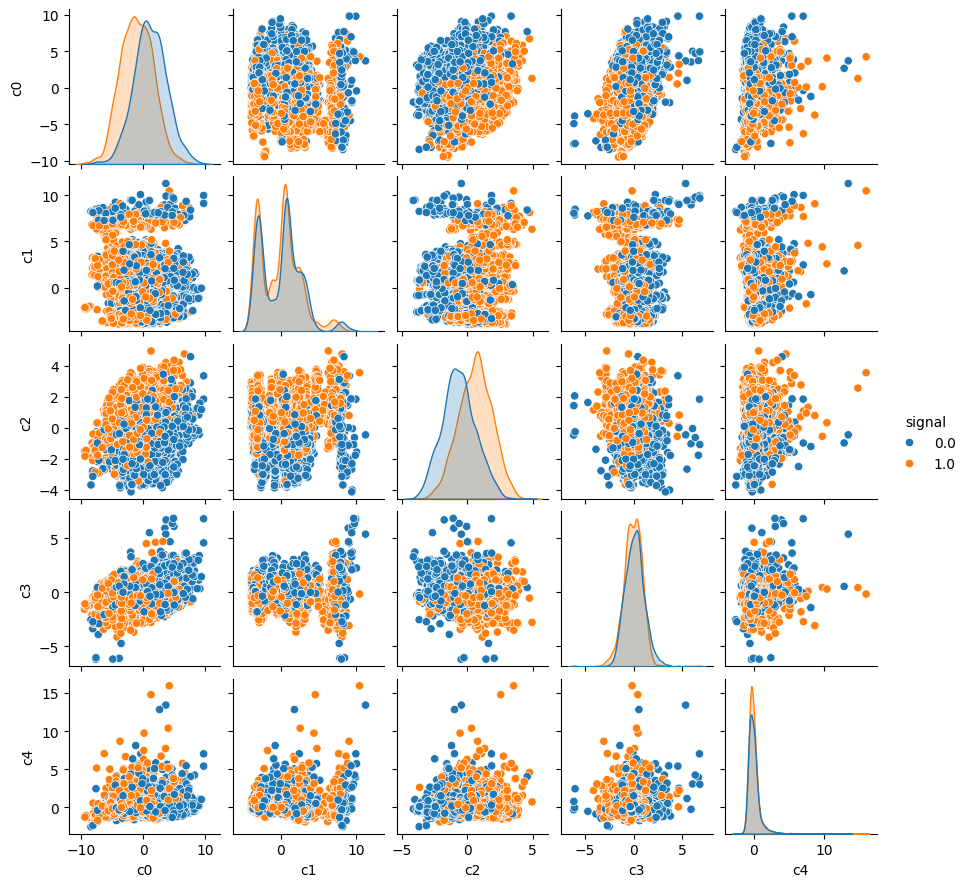

In [ ]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

Observation:

* In the scatter plot of each of the principal component, we can clearly that there is
a clear segregation of the orange and blue dots, which means that data-points
from the same type of signal tend to cluster together.

* However, it’s hard to get a full appreciation of the differences and similarities
between data points across all the components, requiring that the reader hold
comparisons in their head while viewing

As an alternative to the pairs-plots, we could view a 3D scatterplot, which at least lets us see more dimensions at once and possibly get an interactive feel for the data

In [ ]:
# def scatter_3D(A, elevation=30, azimuth=120):

#     maxpts=1000
#     fig = plt.figure(1, figsize=(9, 9))
#     ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
#     ax.set_xlabel('component 0')
#     ax.set_ylabel('component 1')
#     ax.set_zlabel('component 2')

#     # plot subset of points
#     rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
#     coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
#     colors = coloridx[1] / len(coloridx[0])

#     sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
#                ,c=colors, cmap="jet", marker='o', alpha=0.6
#                ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

#     plt.show()

In [ ]:
# dfsvd['signal'] = Y_train
# interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

In this step, we implement another technique of dimensionality reduction - t-SNE and look at the related visualization.We will use the basic implementation available in scikit-learn

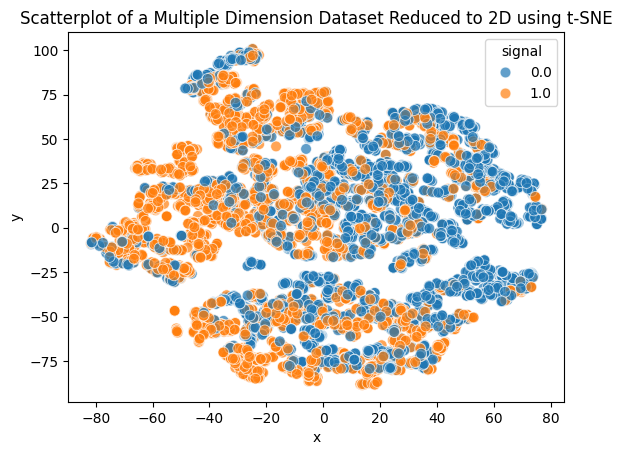

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
dftsne['signal'] = Y_train
sns.scatterplot(x='x', y='y', hue='signal', data=dftsne, alpha=0.7, s=60)
plt.title('Scatterplot of a Multiple Dimension Dataset Reduced to 2D using t-SNE')
plt.show()

In [ ]:
# test options for classification
scoring = 'accuracy'
kfold = 5

In [ ]:
import time
start_time = time.time()

from sklearn.ensemble import RandomForestClassifier
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 10.473700046539307 seconds ---


In [ ]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 5.938628911972046 seconds ---


In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.887125 (0.005009)
Result with dimensionality Reduction: 0.829250 (0.008201)


#1. Part 1 - The base case

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

In [ ]:
!pip install phik

In [ ]:
#load BTC-Hourly.csv.zip
from google.colab import files
uploaded = files.upload()

In [ ]:
import zipfile

# Unzip
with zipfile.ZipFile('BTC-Hourly.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
from datetime import *
from numpy import *
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import scipy.io as sio
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
np.random.seed(1) #to fix the results

def normcdf(X):
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    if X < 0:
        w = 1.0-w
    return w

def vratio(a, lag = 2, cor = 'hom'):
    """ the implementation found in the blog Leinenbock
    http://www.leinenbock.com/variance-ratio-test/
    """
    #t = (std((a[lag:]) - (a[1:-lag+1])))**2;
    #b = (std((a[2:]) - (a[1:-1]) ))**2;

    n = len(a)
    mu  = sum(a[1:n]-a[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    #print( mu, m, lag)
    b=sum(square(a[1:n]-a[:n-1]-mu))/(n-1)
    t=sum(square(a[lag:n]-a[:n-lag]-lag*mu))/m
    vratio = t/(lag*b);

    la = float(lag)

    if cor == 'hom':
        varvrt=2*(2*la-1)*(la-1)/(3*la*n)

    elif cor == 'het':
        varvrt=0;
        sum2=sum(square(a[1:n]-a[:n-1]-mu));
        for j in range(lag-1):
            sum1a=square(a[j+1:n]-a[j:n-1]-mu);
            sum1b=square(a[1:n-j]-a[0:n-j-1]-mu)
            sum1=dot(sum1a,sum1b);
            delta=sum1/(sum2**2);
            varvrt=varvrt+((2*(la-j)/la)**2)*delta

    zscore = (vratio - 1) / sqrt(float(varvrt))
    pval = normcdf(zscore);

    return  vratio, zscore, pval

def hurst2(ts):
    """ the implementation found in the blog Leinenbock
    http://www.leinenbock.com/calculation-of-the-hurst-exponent-to-test-for-trend-and-mean-reversion/
    """
    tau = []; lagvec = []
    #  Step through the different lags
    for lag in range(2,100):
        #  produce price difference with lag
        pp = subtract(ts[lag:],ts[:-lag])
        #  Write the different lags into a vector
        lagvec.append(lag)
        #  Calculate the variance of the differnce vector
        tau.append(sqrt(std(pp)))

    #  linear fit to double-log graph (gives power)
    m = polyfit(log10(lagvec),log10(tau),1)
    # calculate hurst
    hurst = m[0]*2.0
    # plot lag vs variance
    #plt.plot(lagvec,tau,'o')
    #plt.show()

    return hurst

def hurst(ts):
    """ the implewmentation on the blog http://www.quantstart.com
    http://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
    Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def half_life(ts):
    """ this function calculate the half life of mean reversion
    """
    # calculate the delta for each observation.
    # delta = p(t) - p(t-1)
    delta_ts = diff(ts)
        # calculate the vector of lagged prices. lag = 1
    # stack up a vector of ones and transpose
    lag_ts = vstack([ts[1:], ones(len(ts[1:]))]).T

    # calculate the slope (beta) of the deltas vs the lagged values
    beta = linalg.lstsq(lag_ts, delta_ts)

    # compute half life
    half_life = log(2) / beta[0]

    return half_life[0]

def random_walk(seed=1000, mu = 0.0, sigma = 1, length=1000):
    """ this function creates a series of independent, identically distributed values
    with the form of a random walk. Where the best prediction of the next value is the present
    value plus some random variable with mean and variance finite
    We distinguish two types of random walks: (1) random walk without drift (i.e., no constant
    or intercept term) and (2) random walk with drift (i.e., a constant term is present).
    The random walk model is an example of what is known in the literature as a unit root process.
    RWM without drift: Yt = Yt−1 + ut
    RWM with drift: Yt = δ + Yt−1 + ut
    """

    ts = []
    for i in range(length):
        if i == 0:
            ts.append(seed)
        else:
            ts.append(mu + ts[i-1] + random.gauss(0, sigma))

    return ts

def subset_dataframe(data, start_date, end_date):
    start = data.index.searchsorted(start_date)
    end = data.index.searchsorted(end_date)
    return data.ix[start:end]

def cointegration_test(y, x):
    ols_result = sm.OLS(y, x).fit()
    return ts.adfuller(ols_result.resid, maxlag=1)


def get_data_from_matlab(file_url, index, columns, data):
    """Description:*
    This function takes a Matlab file .mat and extract some
    information to a pandas data frame. The structure of the mat
    file must be known, as the loadmat function used returns a
    dictionary of arrays and they must be called by the key name

    Args:
        file_url: the ubication of the .mat file
        index: the key for the array of string date-like to be used as index
        for the dataframe
        columns: the key for the array of data to be used as columns in
        the dataframe
        data: the key for the array to be used as data in the dataframe
    Returns:
        Pandas dataframe

    """

    import scipy.io as sio
    import datetime as dt
    # load mat file to dictionary
    mat = sio.loadmat(file_url)
    # define data to import, columns names and index
    cl = mat[data]
    stocks = mat[columns]
    dates = mat[index]

    # extract the ticket to be used as columns name in dataframe
    # to-do: list compression here
    columns = []
    for each_item in stocks:
        for inside_item in each_item:
            for ticket in inside_item:
                columns.append(ticket)
    # extract string ins date array and convert to datetimeindex
    # to-do list compression here
    df_dates =[]
    for each_item in dates:
        for inside_item in each_item:
            df_dates.append(inside_item)
    df_dates = pd.Series([pd.to_datetime(date, format= '%Y%m%d') for date in df_dates], name='date')

    # construct the final dataframe
    data = pd.DataFrame(cl, columns=columns, index=df_dates)

    return data


def my_path(loc):
    if loc == 'PC':
        root_path = 'C:/Users/javgar119/Documents/Python/Data/'
    elif loc == 'MAC':
        root_path = '/Users/Javi/Documents/MarketData/'
    return root_path

# import pandas as pd
from matplotlib import pyplot
import numpy as np
# import statsmodels.api as sm

def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid

#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    ser = np.log(ser+1)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5]))
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break

    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)



    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.axvline(x = ave, color = 'b', label = 'axvline - full height')
   # plt.show()

def backshift(day,x):
    assert day > 0,'Invalid day'
    shift = np.zeros((np.shape(x)))
    shift[day:] = x[:-day]
    shift[shift==0] = np.nan
    return shift

def calculateReturns(prices, lag):
    prevPrices = backshift(lag, prices)
    rlag = (prices - prevPrices) / prevPrices
    return rlag

def fwdshift(day,x):
    assert day > 0,'Invalid day'
    shift = np.zeros((np.shape(x)))
    shift[:-day] = x[day:]
    shift[shift==0] = np.nan
    return shift

def calculateMaxDD(cumret):
    highwatermark = np.zeros(len(cumret))
    drawdown      = np.zeros(len(cumret))
    drawdownduration = np.zeros(len(cumret))
    for t in range(1, len(cumret)):
        highwatermark[t] = np.max([highwatermark[t-1], cumret[t]])
        drawdown[t] = (1+cumret[t]) / (1 + highwatermark[t]) - 1
        if (drawdown[t]==0):
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    return np.min(drawdown), np.max(drawdownduration)

In [ ]:
df = pd.read_csv('BTC-Hourly.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01 00:00:00,1646092800,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,1646089200,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2022-02-28 22:00:00,1646085600,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
2022-02-28 21:00:00,1646082000,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
2022-02-28 20:00:00,1646078400,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
df = df.drop(['unix','symbol'], axis=1)
df.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
#save the close and open for white reality check
openp = df['open'].copy() #for the case we want to enter trades at the open
close = df['close'].copy() #for the case we want to enter trades at the close

#Create short simple moving average over the short window
df['short_mavg'] = df['open'].pct_change(periods=10).shift(-1).fillna(0)
#Create long simple moving average over the long window
df['long_mavg'] = df['open'].pct_change(periods=60).shift(-1).fillna(0)
#Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

#Since we are trading right after the open,
#we only know yesterday's  high low close volume etc.
df['high'] = df['high'].shift(1).fillna(0)
df['low'] = df['low'].shift(1).fillna(0)
df['close'] = df['close'].shift(1).fillna(0)
df['Volume BTC'] = df['Volume BTC'].shift(1).fillna(0)
df['Volume USD'] = df['Volume USD'].shift(1).fillna(0)

#Build the same features from the original method
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA10'] = EMA(df, 10)
df['EMA30'] = EMA(df, 30)
df['EMA200'] = EMA(df, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    # Cap extreme values to avoid issues
    M = M.clip(lower=-1e6, upper=1e6)
    N = N.clip(lower=1e-6)  # Ensure no division by zero
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC
df['ROC10'] = ROC(df['close'], 10)
df['ROC30'] = ROC(df['close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM10'] = MOM(df['close'], 10)
df['MOM30'] = MOM(df['close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period])  # First value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period])  # First value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / (d.ewm(com=period-1, adjust=False).mean())
    return 100 - 100 / (1 + rs)
df['RSI10'] = RSI(df['close'], 10)
df['RSI30'] = RSI(df['close'], 30)
df['RSI200'] = RSI(df['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

df['%K10'] = STOK(df['close'], df['low'], df['high'], 10)
df['%D10'] = STOD(df['close'], df['low'], df['high'], 10)
df['%K30'] = STOK(df['close'], df['low'], df['high'], 30)
df['%D30'] = STOD(df['close'], df['low'], df['high'], 30)
df['%K200'] = STOK(df['close'], df['low'], df['high'], 200)
df['%D200'] = STOD(df['close'], df['low'], df['high'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA21'] = MA(df, 10)
df['MA63'] = MA(df, 30)
df['MA252'] = MA(df, 200)

In [ ]:
df.tail()

,open,high,low,close,Volume BTC,Volume USD,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,,,
2018-05-15 10:00:00,8708.32,8821.19,8740.54,8760.00,2842987.30,324.11,0.023672,0.064359,0.0,8611.609034,...,56.258310,85.472115,90.870165,91.515294,94.744275,95.584181,97.289875,8599.322,8398.227000,8254.33045
2018-05-15 09:00:00,8728.49,8865.00,8695.11,8795.90,11101273.74,1260.69,0.022543,0.068817,0.0,8645.116482,...,56.497126,85.139785,86.976002,90.967202,92.319027,95.166176,95.972866,8627.702,8415.643667,8260.83340
2018-05-15 08:00:00,8739.00,8754.40,8701.35,8708.32,1593991.98,182.62,0.024107,0.070413,0.0,8656.608031,...,55.750839,66.305376,78.972425,79.518687,87.333728,88.052463,92.934273,8642.974,8429.727667,8266.79360
2018-05-15 07:00:00,8740.99,8750.27,8660.53,8728.49,7986062.84,917.79,0.025065,0.057664,0.0,8669.677480,...,55.885715,65.664772,72.369978,82.155322,84.213737,88.516316,90.578318,8663.158,8446.510667,8272.30915
2018-05-15 06:00:00,8733.86,8766.00,8721.11,8739.00,2390398.89,273.58,0.000000,0.000000,0.0,8682.281574,...,55.956021,68.308265,66.759471,83.529196,81.734402,88.157672,88.242150,8682.424,8465.144333,8277.45405


In [ ]:
#excluding columns that are not needed for our prediction.
df_filtered = df.drop(['high','low','close','Volume USD'], axis=1)

#distribute the df data into X inputs and y target
# X = df_filtered.drop(['retFut1','retFut1_categ'], axis=1)
# y = df_filtered[['retFut1_categ']]
X = df_filtered.drop(['short_mavg','long_mavg','signal'], axis=1)
y = df_filtered[['signal']]

#select the samples
x_train = X.iloc[0:8000]
x_test = X.iloc[8000:10000]

y_train = y.iloc[0:8000]
y_test = y.iloc[8000:10000]

df_train = df_filtered.iloc[0:8000]
df_test = df_filtered.iloc[8000:10000]

In [ ]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig)
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr

myscorer = make_scorer(phi_k, greater_is_better=True)
# myscorer = None #use default accuracy score

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD())])
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64','int32']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
# #use logistic regression
# logistic = LogisticRegression(max_iter=1000, solver='liblinear')

# pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])

# ncomponents_rs = np.arange(2, 15+1) #from 2 to 15
# c_rs = np.logspace(3, -4, num=20, endpoint = True)
# p_rs= ["l1", "l2"] #penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)

# param_grid =  [{'preprocessor__num__pca__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#use random forest classifier
rfc = RandomForestClassifier(n_jobs=-1)

pipe = Pipeline(steps=[('preprocessor', preprocessor),('rfc', rfc)])

ncomponents_rs = np.array([5]) #use 5 principal components
n_estimators_rs = np.array([100]) #use the default value 100

# ncomponents_rs = np.arange(2, 15+1) #from 2 to 15
# n_estimators_rs = np.array([50,100,200])

param_grid =  [{'preprocessor__num__svd__n_components': ncomponents_rs, 'rfc__n_estimators': n_estimators_rs}]
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters : {}".format(best_parameters))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

# print(results.T)
# results.to_csv("results_logisticreg.csv")

open          float64
Volume BTC    float64
EMA10         float64
EMA30         float64
EMA200        float64
ROC10         float64
ROC30         float64
MOM10         float64
MOM30         float64
RSI10         float64
RSI30         float64
RSI200        float64
%K10          float64
%D10          float64
%K30          float64
%D30          float64
%K200         float64
%D200         float64
MA21          float64
MA63          float64
MA252         float64
dtype: object
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Best parameters : {'rfc__n_estimators': 100, 'preprocessor__num__svd__n_components': 5}
Best cross-validation score : 58.77


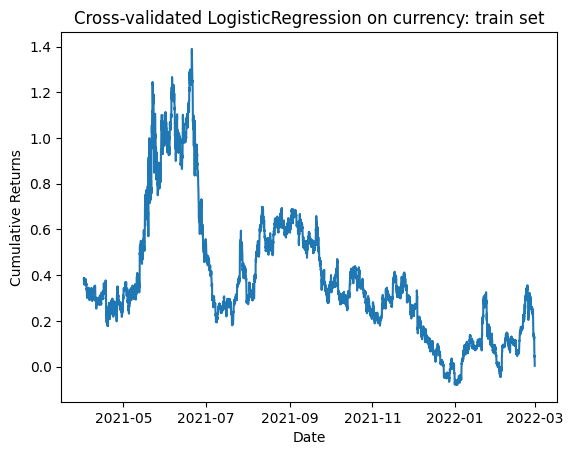

In-sample: CAGR=0.0102134 Sharpe ratio=0.143094 maxDD=-0.507509 maxDDD=2140 Calmar ratio=0.0201245



In [ ]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
dailyRet = pd.Series(positions).fillna(0).values * df_train['open'].pct_change(1).shift(-1).fillna(0) #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

# plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()
# plt.savefig(r'Results\%s.png' %("TrainCumulative"))

cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

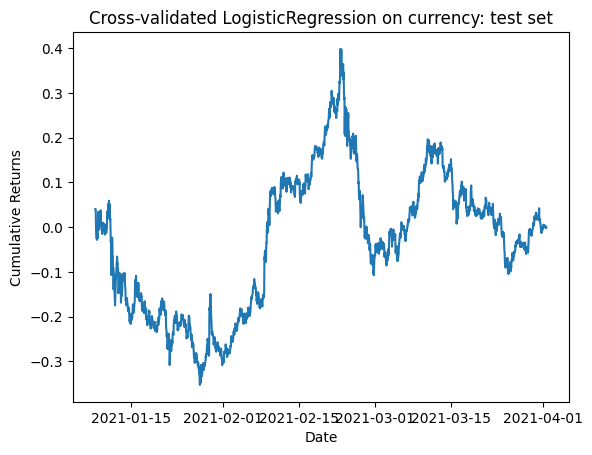

In [ ]:
# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

#dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * x_test.ret1 #for trading at the close
dailyRet2 = pd.Series(positions2).fillna(0).values * df_test['open'].pct_change(1).shift(-1).fillna(0) #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

# plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative"))

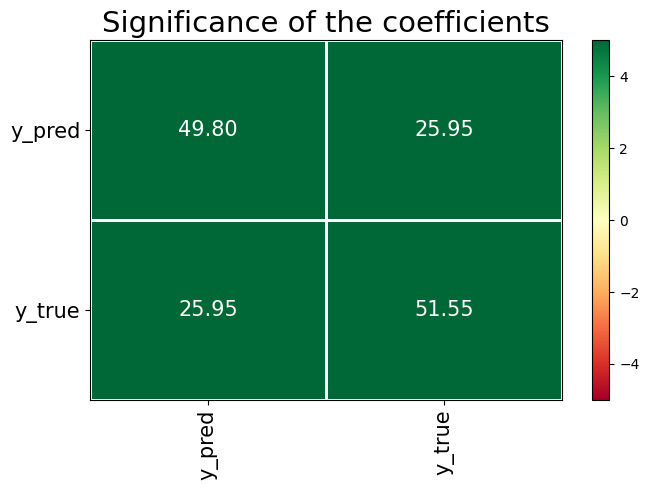

Out-of-sample: CAGR=0.00502738 Sharpe ratio=0.117758 maxDD=-0.536865 maxDDD=1086 Calmar ratio=0.00936432  phi_k_corr=0.781099 phi_k_p_val=0.0  accuracy_score=0.7975



In [ ]:
#metrics
accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
plt.show()
# plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accuracy_score))

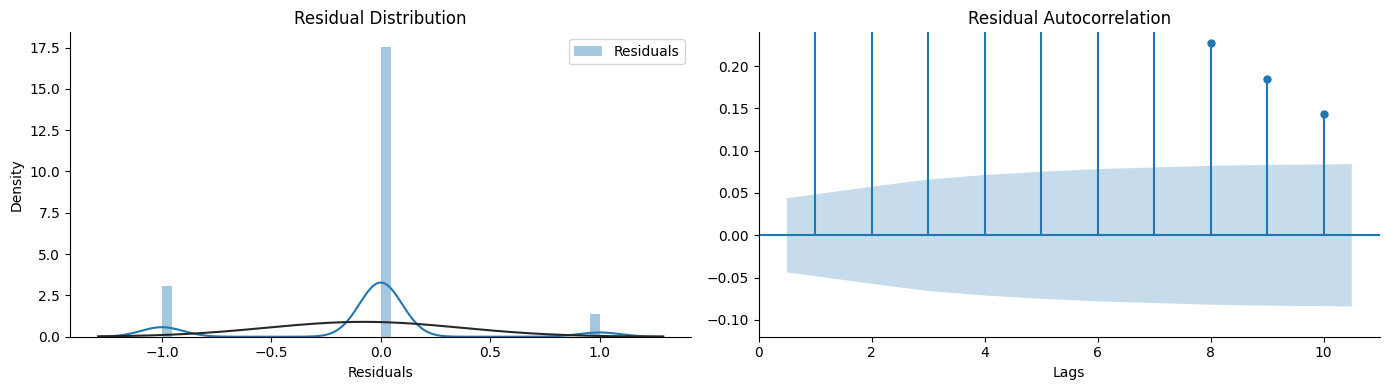

In [ ]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
axes[1].set_ylim(-0.12, 0.24)
sns.despine()
fig.tight_layout();
plt.show()
# plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
# plt.close("all")

Ljung-Box test p-value 0.0
average return 0.000490
[-0.00190417  0.00181313]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.2984


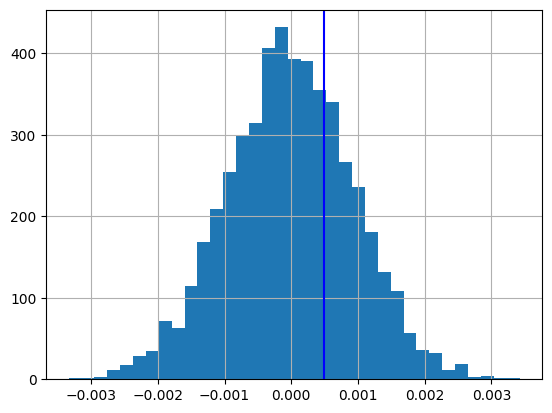

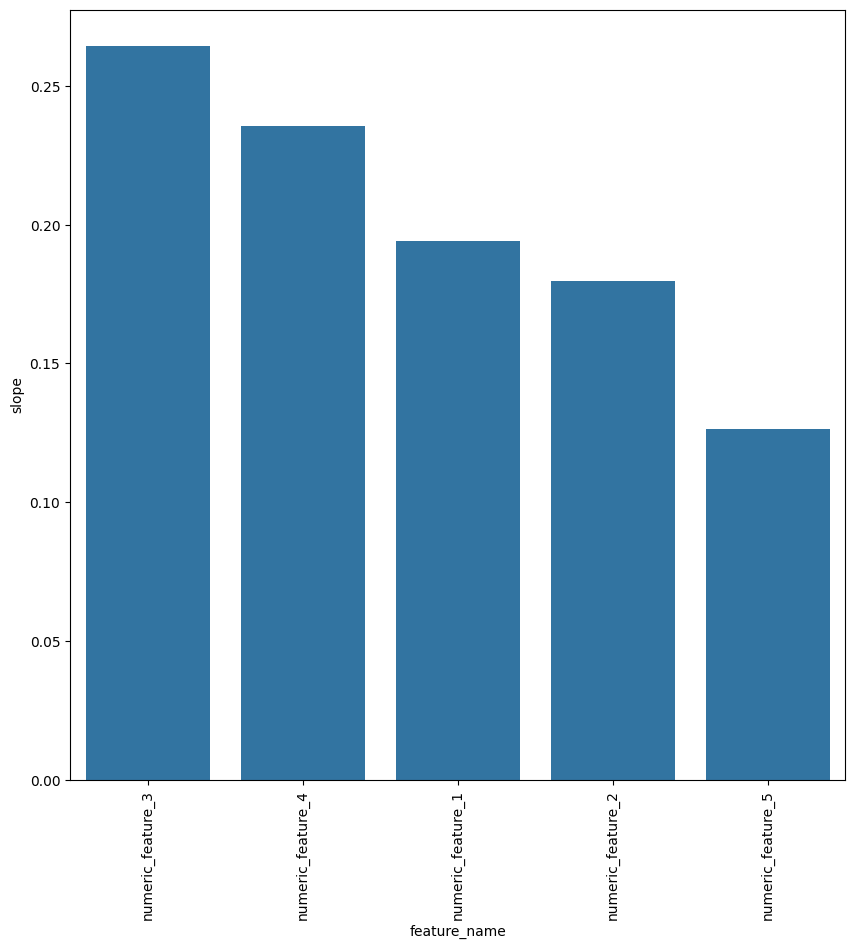

In [ ]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.loc[10, 'lb_pvalue'])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)
plt.show()

# column_names = []
# num_numeric = best_parameters['preprocessor__num__svd__n_components']
# for i in range(1,num_numeric+1):
#     column_names.append('numeric_features_'+str(i))
# num_dummies = len(best_model[1].coef_.ravel().tolist())-num_numeric
# for i in range(1,num_dummies+1):
#     column_names.append('dummies_'+str(i))

# ##plot the coefficients
# plt.figure(figsize=(10, 10))
# importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
# importance.columns = ['slope','feature_name']
# importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
# for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
#     item.set_rotation(90)
# plt.show()

#Get feature importances from the RandomForestClassifier
importances = best_model[1].feature_importances_
#Create a list of column names for numeric features
num_numeric = best_parameters['preprocessor__num__svd__n_components']
column_names = ['numeric_feature_' + str(i) for i in range(1, num_numeric + 1)]
#Get the remaining feature names as dummy features
num_dummies = len(importances) - num_numeric
column_names += ['dummy_feature_' + str(i) for i in range(1, num_dummies + 1)]
plt.figure(figsize=(10, 10))
#Get feature importances from the RandomForestClassifier
importances = best_model[1].feature_importances_
#Create a DataFrame with feature importances and corresponding names
importance = pd.DataFrame({'slope': importances, 'feature_name': column_names})
#Sort the DataFrame by feature importance in descending order
importance = importance.sort_values(by='slope', ascending=False)
#Create the bar plot
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], orient='v', dodge=False)
importance_plot.set_xticklabels(importance_plot.get_xticklabels(), rotation=90)  # Rotate x labels
plt.show()

# plt.savefig(r'Results\%s.png' %("Coefficients"))

#2. Part 2 - Modified case one (PCA, logistic regression)

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

!pip install phik
!pip install category-encoders

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4183    0  4183    0     0  14227      0 --:--:-- --:--:-- --:--:-- 14276
100  517k  100  517k    0     0   577k      0 --:--:-- --:--:-- --:--:-- 2002k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4183    0  4183    0     0  13701      0 --:--:-- --:--:-- --:--:-- 13714
100  392k  100  392k    0     0   548k      0 --:--:-- --:--:-- --:--:-- 1869k
Download complete.


In [ ]:
#load BTC-Hourly.csv.zip
from google.colab import files
uploaded = files.upload()

Saving BTC-Hourly.csv.zip to BTC-Hourly.csv.zip


In [ ]:
import zipfile

# Unzip
with zipfile.ZipFile('BTC-Hourly.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Define some useful functions below:

In [ ]:
from datetime import *
from numpy import *
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import scipy.io as sio
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
np.random.seed(1) #to fix the results

def normcdf(X):
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    if X < 0:
        w = 1.0-w
    return w

def vratio(a, lag = 2, cor = 'hom'):
    """ the implementation found in the blog Leinenbock
    http://www.leinenbock.com/variance-ratio-test/
    """
    #t = (std((a[lag:]) - (a[1:-lag+1])))**2;
    #b = (std((a[2:]) - (a[1:-1]) ))**2;

    n = len(a)
    mu  = sum(a[1:n]-a[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    #print( mu, m, lag)
    b=sum(square(a[1:n]-a[:n-1]-mu))/(n-1)
    t=sum(square(a[lag:n]-a[:n-lag]-lag*mu))/m
    vratio = t/(lag*b);

    la = float(lag)

    if cor == 'hom':
        varvrt=2*(2*la-1)*(la-1)/(3*la*n)

    elif cor == 'het':
        varvrt=0;
        sum2=sum(square(a[1:n]-a[:n-1]-mu));
        for j in range(lag-1):
            sum1a=square(a[j+1:n]-a[j:n-1]-mu);
            sum1b=square(a[1:n-j]-a[0:n-j-1]-mu)
            sum1=dot(sum1a,sum1b);
            delta=sum1/(sum2**2);
            varvrt=varvrt+((2*(la-j)/la)**2)*delta

    zscore = (vratio - 1) / sqrt(float(varvrt))
    pval = normcdf(zscore);

    return  vratio, zscore, pval

def hurst2(ts):
    """ the implementation found in the blog Leinenbock
    http://www.leinenbock.com/calculation-of-the-hurst-exponent-to-test-for-trend-and-mean-reversion/
    """
    tau = []; lagvec = []
    #  Step through the different lags
    for lag in range(2,100):
        #  produce price difference with lag
        pp = subtract(ts[lag:],ts[:-lag])
        #  Write the different lags into a vector
        lagvec.append(lag)
        #  Calculate the variance of the differnce vector
        tau.append(sqrt(std(pp)))

    #  linear fit to double-log graph (gives power)
    m = polyfit(log10(lagvec),log10(tau),1)
    # calculate hurst
    hurst = m[0]*2.0
    # plot lag vs variance
    #plt.plot(lagvec,tau,'o')
    #plt.show()

    return hurst

def hurst(ts):
    """ the implewmentation on the blog http://www.quantstart.com
    http://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
    Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def half_life(ts):
    """ this function calculate the half life of mean reversion
    """
    # calculate the delta for each observation.
    # delta = p(t) - p(t-1)
    delta_ts = diff(ts)
        # calculate the vector of lagged prices. lag = 1
    # stack up a vector of ones and transpose
    lag_ts = vstack([ts[1:], ones(len(ts[1:]))]).T

    # calculate the slope (beta) of the deltas vs the lagged values
    beta = linalg.lstsq(lag_ts, delta_ts)

    # compute half life
    half_life = log(2) / beta[0]

    return half_life[0]

def random_walk(seed=1000, mu = 0.0, sigma = 1, length=1000):
    """ this function creates a series of independent, identically distributed values
    with the form of a random walk. Where the best prediction of the next value is the present
    value plus some random variable with mean and variance finite
    We distinguish two types of random walks: (1) random walk without drift (i.e., no constant
    or intercept term) and (2) random walk with drift (i.e., a constant term is present).
    The random walk model is an example of what is known in the literature as a unit root process.
    RWM without drift: Yt = Yt−1 + ut
    RWM with drift: Yt = δ + Yt−1 + ut
    """

    ts = []
    for i in range(length):
        if i == 0:
            ts.append(seed)
        else:
            ts.append(mu + ts[i-1] + random.gauss(0, sigma))

    return ts

def subset_dataframe(data, start_date, end_date):
    start = data.index.searchsorted(start_date)
    end = data.index.searchsorted(end_date)
    return data.ix[start:end]

def cointegration_test(y, x):
    ols_result = sm.OLS(y, x).fit()
    return ts.adfuller(ols_result.resid, maxlag=1)


def get_data_from_matlab(file_url, index, columns, data):
    """Description:*
    This function takes a Matlab file .mat and extract some
    information to a pandas data frame. The structure of the mat
    file must be known, as the loadmat function used returns a
    dictionary of arrays and they must be called by the key name

    Args:
        file_url: the ubication of the .mat file
        index: the key for the array of string date-like to be used as index
        for the dataframe
        columns: the key for the array of data to be used as columns in
        the dataframe
        data: the key for the array to be used as data in the dataframe
    Returns:
        Pandas dataframe

    """

    import scipy.io as sio
    import datetime as dt
    # load mat file to dictionary
    mat = sio.loadmat(file_url)
    # define data to import, columns names and index
    cl = mat[data]
    stocks = mat[columns]
    dates = mat[index]

    # extract the ticket to be used as columns name in dataframe
    # to-do: list compression here
    columns = []
    for each_item in stocks:
        for inside_item in each_item:
            for ticket in inside_item:
                columns.append(ticket)
    # extract string ins date array and convert to datetimeindex
    # to-do list compression here
    df_dates =[]
    for each_item in dates:
        for inside_item in each_item:
            df_dates.append(inside_item)
    df_dates = pd.Series([pd.to_datetime(date, format= '%Y%m%d') for date in df_dates], name='date')

    # construct the final dataframe
    data = pd.DataFrame(cl, columns=columns, index=df_dates)

    return data


def my_path(loc):
    if loc == 'PC':
        root_path = 'C:/Users/javgar119/Documents/Python/Data/'
    elif loc == 'MAC':
        root_path = '/Users/Javi/Documents/MarketData/'
    return root_path

# import pandas as pd
from matplotlib import pyplot
import numpy as np
# import statsmodels.api as sm

def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid

#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    ser = np.log(ser+1)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5]))
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break

    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)



    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.axvline(x = ave, color = 'b', label = 'axvline - full height')
   # plt.show()

def backshift(day,x):
    assert day > 0,'Invalid day'
    shift = np.zeros((np.shape(x)))
    shift[day:] = x[:-day]
    shift[shift==0] = np.nan
    return shift

def calculateReturns(prices, lag):
    prevPrices = backshift(lag, prices)
    rlag = (prices - prevPrices) / prevPrices
    return rlag

def fwdshift(day,x):
    assert day > 0,'Invalid day'
    shift = np.zeros((np.shape(x)))
    shift[:-day] = x[day:]
    shift[shift==0] = np.nan
    return shift

def calculateMaxDD(cumret):
    highwatermark = np.zeros(len(cumret))
    drawdown      = np.zeros(len(cumret))
    drawdownduration = np.zeros(len(cumret))
    for t in range(1, len(cumret)):
        highwatermark[t] = np.max([highwatermark[t-1], cumret[t]])
        drawdown[t] = (1+cumret[t]) / (1 + highwatermark[t]) - 1
        if (drawdown[t]==0):
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    return np.min(drawdown), np.max(drawdownduration)

In [ ]:
df = pd.read_csv('BTC-Hourly.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01 00:00:00,1646092800,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,1646089200,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2022-02-28 22:00:00,1646085600,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
2022-02-28 21:00:00,1646082000,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
2022-02-28 20:00:00,1646078400,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
df = df.drop(['unix','symbol'], axis=1)
df.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
# # Drop NaN values from the 'close' column
# close_prices = df['close'].dropna()

# # Compute volatility as standard deviation of hourly returns
# volatility = np.std(close_prices.pct_change())

# print("Volatility (Standard Deviation of Hourly Returns):", volatility)

In [ ]:
#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#save the close and open for white reality check
openp = df['open'].copy() #for the case we want to enter trades at the open
close = df['close'].copy() #for the case we want to enter trades at the close

#buld window features:
# for n in list(range(1,10)):  #use 5 instead of 21 because it takes a long time
#     name = 'ret' + str(n)
#     df[name] = df["open"].pct_change(periods=n) #for trading with open

#new window features
# df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
# lg=3
# df['vratio']=df['ret1'].rolling(100*lg).apply(lambda s: vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
# df['retFut1'] = df['open'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
# df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0) #transform the target
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#Create short simple moving average over the short window
df['short_mavg'] = df['open'].pct_change(periods=10).shift(-1).fillna(0)
#Create long simple moving average over the long window
df['long_mavg'] = df['open'].pct_change(periods=60).shift(-1).fillna(0)
#Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

#Since we are trading right after the open,
#we only know yesterday's  high low close volume etc.
df['high'] = df['high'].shift(1).fillna(0)
df['low'] = df['low'].shift(1).fillna(0)
df['close'] = df['close'].shift(1).fillna(0)
df['Volume BTC'] = df['Volume BTC'].shift(1).fillna(0)
df['Volume USD'] = df['Volume USD'].shift(1).fillna(0)

#Build some Ta-lib features
df['SMA10'] = df['close'].rolling(window=10).mean()
df['SMA30'] = df['close'].rolling(window=30).mean()
df['SMA200'] = df['close'].rolling(window=200).mean()
df['Corr10']= df['close'].rolling(window=10).corr(df['SMA10'])
df['Corr30']= df['close'].rolling(window=30).corr(df['SMA30'])
df['Corr200']= df['close'].rolling(window=200).corr(df['SMA200'])
df['SAR']=ta.SAR(np.array(df['high']),np.array(df['low']), 0.2, 0.2)
df['ADX10']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=10)
df['ADX30']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=30)
df['ADX200']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=200)
df['OO']= df['open']-df['open'].shift(1)
df['OC']= df['open']-df['close']
df.fillna(0, inplace=True)

#Build volume momentum features
# Define the function to compute volume momentum
# def compute_volume_momentum(column):
#   lookback = 10
#   mult = 20
#   raw = np.log(column.rolling(window=lookback).mean()) - np.log(column.rolling(window=lookback*mult).mean())  # raw calculation
#   # volume_momentum = 100 * norm.cdf(3 * raw / np.cbrt(mult)) - 50  # volume momentum
#   return raw

# df['BTC_VM'] = compute_volume_momentum(df['Volume BTC'])
# df['USD_VM'] = compute_volume_momentum(df['Volume USD'])

#Build the same features from the original method
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA10'] = EMA(df, 10)
df['EMA30'] = EMA(df, 30)
df['EMA200'] = EMA(df, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    # Cap extreme values to avoid issues
    M = M.clip(lower=-1e6, upper=1e6)
    N = N.clip(lower=1e-6)  # Ensure no division by zero
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC
df['ROC10'] = ROC(df['close'], 10)
df['ROC30'] = ROC(df['close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM10'] = MOM(df['close'], 10)
df['MOM30'] = MOM(df['close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period])  # First value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period])  # First value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / (d.ewm(com=period-1, adjust=False).mean())
    return 100 - 100 / (1 + rs)
df['RSI10'] = RSI(df['close'], 10)
df['RSI30'] = RSI(df['close'], 30)
df['RSI200'] = RSI(df['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

df['%K10'] = STOK(df['close'], df['low'], df['high'], 10)
df['%D10'] = STOD(df['close'], df['low'], df['high'], 10)
df['%K30'] = STOK(df['close'], df['low'], df['high'], 30)
df['%D30'] = STOD(df['close'], df['low'], df['high'], 30)
df['%K200'] = STOK(df['close'], df['low'], df['high'], 200)
df['%D200'] = STOD(df['close'], df['low'], df['high'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA21'] = MA(df, 10)
df['MA63'] = MA(df, 30)
df['MA252'] = MA(df, 200)

In [ ]:
df.tail()

,open,high,low,close,Volume BTC,Volume USD,hour,day,short_mavg,long_mavg,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,,,
2018-05-15 10:00:00,8708.32,8821.19,8740.54,8760.00,2842987.30,324.11,10,1,0.023672,0.064359,...,56.258310,85.472115,90.870165,91.515294,94.744275,95.584181,97.289875,8599.322,8398.227000,8254.33045
2018-05-15 09:00:00,8728.49,8865.00,8695.11,8795.90,11101273.74,1260.69,9,1,0.022543,0.068817,...,56.497126,85.139785,86.976002,90.967202,92.319027,95.166176,95.972866,8627.702,8415.643667,8260.83340
2018-05-15 08:00:00,8739.00,8754.40,8701.35,8708.32,1593991.98,182.62,8,1,0.024107,0.070413,...,55.750839,66.305376,78.972425,79.518687,87.333728,88.052463,92.934273,8642.974,8429.727667,8266.79360
2018-05-15 07:00:00,8740.99,8750.27,8660.53,8728.49,7986062.84,917.79,7,1,0.025065,0.057664,...,55.885715,65.664772,72.369978,82.155322,84.213737,88.516316,90.578318,8663.158,8446.510667,8272.30915
2018-05-15 06:00:00,8733.86,8766.00,8721.11,8739.00,2390398.89,273.58,6,1,0.000000,0.000000,...,55.956021,68.308265,66.759471,83.529196,81.734402,88.157672,88.242150,8682.424,8465.144333,8277.45405


In [ ]:
#excluding columns that are not needed for our prediction.
df_filtered = df.drop(['high','low','close'], axis=1) #optional

#distribute the df data into X inputs and y target
# X = df_filtered.drop(['retFut1','retFut1_categ'], axis=1)
# y = df_filtered[['retFut1_categ']]
X = df_filtered.drop(['short_mavg','long_mavg','signal'], axis=1)
y = df_filtered[['signal']]

#select the samples
x_train = X.iloc[0:8000]
x_test = X.iloc[8000:10000]

y_train = y.iloc[0:8000]
y_test = y.iloc[8000:10000]

df_train = df_filtered.iloc[0:8000]
df_test = df_filtered.iloc[8000:10000]

In [ ]:
# Check for infinity in each column
columns_with_inf = []
for col in x_train.columns:
    if np.any(np.isinf(x_train[col])):
        columns_with_inf.append(col)

# Check for values too large in each column
columns_with_large_values = []
for col in x_train.columns:
    if np.any(np.abs(x_train[col]) > np.finfo(np.float64).max):
        columns_with_large_values.append(col)

if columns_with_inf:
    print("Columns with infinite values:", columns_with_inf)
else:
    print("Columns have no infinite values")

if columns_with_large_values:
    print("Columns with values that are too large:", columns_with_large_values)
else:
    print("Columns have no too large values")

Columns have no infinite values
Columns have no too large values


In [ ]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig)
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr

def target_encoder (X, y):
    # use target encoding to encode the categorical features
    x_train_enc = pd.DataFrame(X, columns=x_train.columns)
    y_train_enc = X.join(y).signal
    enc = TargetEncoder(cols=['hour', 'day'])
    # transform the datasets
    x_train_enc = enc.fit_transform(x_train_enc, y_train_enc)
    x_train_enc =x_train_enc.fillna(0)
    return x_train_enc

myscorer = make_scorer(phi_k, greater_is_better=True)
# myscorer = None #use default accuracy score

# numeric_sub_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler()),
#     ('pca', PCA())])
# categorical_sub_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

targetencoder = FunctionTransformer(target_encoder,kw_args={'y': y_train})

print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64','int32']).columns
all_features_ix = x_train.columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_sub_pipeline, numeric_features_ix),
#         ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

categorical_features_no = []
for i in categorical_features_ix:
    categorical_features_no.append(x_train.columns.get_loc(i))

numeric_features_no = []
for i in numeric_features_ix:
    numeric_features_no.append(x_train.columns.get_loc(i))

all_features_no = []
for i in all_features_ix:
    all_features_no.append(x_train.columns.get_loc(i))

encoder = ColumnTransformer(transformers=[('target', targetencoder, all_features_no)], remainder='passthrough')
imputer = ColumnTransformer(transformers=[('imputer', SimpleImputer(strategy='constant', fill_value=0), numeric_features_no)], remainder='passthrough')
extractor = ColumnTransformer(transformers=[('pca', PCA(), numeric_features_no)], remainder='passthrough')

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#use logistic regression
logistic = LogisticRegression(max_iter=1000, solver='liblinear')

# pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])
pipe = Pipeline(steps=[('encoder', encoder),('imputer', imputer),('t5', extractor),('logistic', logistic)])

ncomponents_rs = np.arange(2, len(numeric_features_ix)+1) #from 2 to max possible
c_rs = np.logspace(3, -4, num=20, endpoint = True)
p_rs= ["l1", "l2"] #penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)

# param_grid =  [{'preprocessor__num__pca__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]
param_grid =  {'t5__pca__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
# #use random forest classifier
# rfc = RandomForestClassifier(n_jobs=-1)

# pipe = Pipeline(steps=[('preprocessor', preprocessor),('rfc', rfc)])

# ncomponents_rs = np.arange(2, 15+1) #from 2 to 15
# n_estimators_rs = np.array([50,100,200])

# param_grid =  [{'preprocessor__num__pca__n_components': ncomponents_rs, 'rfc__n_estimators': n_estimators_rs}]
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters : {}".format(best_parameters))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

# print(results.T)
# results.to_csv("results_logisticreg.csv")

open          float64
Volume BTC    float64
Volume USD    float64
hour            int32
day             int32
SMA10         float64
SMA30         float64
SMA200        float64
Corr10        float64
Corr30        float64
Corr200       float64
SAR           float64
ADX10         float64
ADX30         float64
ADX200        float64
OO            float64
OC            float64
EMA10         float64
EMA30         float64
EMA200        float64
ROC10         float64
ROC30         float64
MOM10         float64
MOM30         float64
RSI10         float64
RSI30         float64
RSI200        float64
%K10          float64
%D10          float64
%K30          float64
%D30          float64
%K200         float64
%D200         float64
MA21          float64
MA63          float64
MA252         float64
dtype: object
0.0
0.0
0
0.2894791559388349
0.10715721092709862
0.6570145278511355
0
0.24000694187244132
0.000933130768116408
0.008164722515574097
0.0
0.0
0
0.23421868098946197
0.12311590861141997
0.6910893136

In [ ]:
# from sklearn.model_selection import train_test_split, KFold, cross_val_score
# from sklearn.decomposition import TruncatedSVD

# validation_size = 0.2
# seed = 1
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=validation_size, random_state=1)

# scaler = StandardScaler().fit(X_train)
# rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# # summarize transformed data
# X_train.dropna(how='any', inplace=True)
# rescaledDataset.dropna(how='any', inplace=True)
# Y_train = Y_train.loc[X_train.index] # Align Y_train with the dropped indices from X_train
# # rescaledDataset.head(2)

# from matplotlib.ticker import MaxNLocator
# ncomps = 15
# svd = TruncatedSVD(n_components=ncomps)
# svd_fit = svd.fit(rescaledDataset)
# plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
# plt_data.index = np.arange(1, len(plt_data) + 1)
# Y_pred = svd.fit_transform(rescaledDataset)
# dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
# svdcols = [c for c in dfsvd.columns if c[0] == 'c']

# # test options for classification
# scoring = 'accuracy'
# kfold = 5

# import time
# start_time = time.time()

# # spot check the algorithms
# models =  RandomForestClassifier(n_jobs=-1)
# cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
# print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# X_SVD= dfsvd[svdcols].iloc[:,:5]
# cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
# print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

# print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
# print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

In [ ]:
# from matplotlib.ticker import MaxNLocator
# ncomps = 15
# svd = TruncatedSVD(n_components=ncomps)
# svd_fit = svd.fit(rescaledDataset)
# plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
# plt_data.index = np.arange(1, len(plt_data) + 1)
# Y_pred = svd.fit_transform(rescaledDataset)
# ax = plt_data.plot(kind='line', figsize=(10, 4))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xlabel("Eigenvalues")
# ax.set_ylabel("Percentage Explained")
# ax.legend("")
# print('Variance preserved by first 6 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [ ]:
# print('Best estimator {}'.format(best_model))

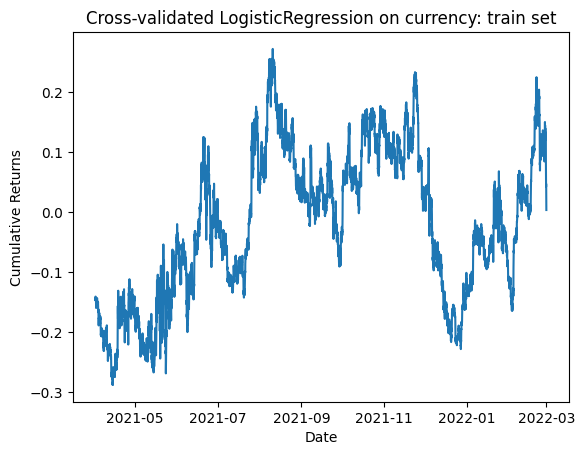

In-sample: CAGR=-0.00494471 Sharpe ratio=0.0298061 maxDD=-0.440597 maxDDD=3145 Calmar ratio=-0.0112228



In [ ]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
dailyRet = pd.Series(positions).fillna(0).values * df_train['open'].pct_change(1).shift(-1).fillna(0) #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

# plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()
# plt.savefig(r'Results\%s.png' %("TrainCumulative"))

cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

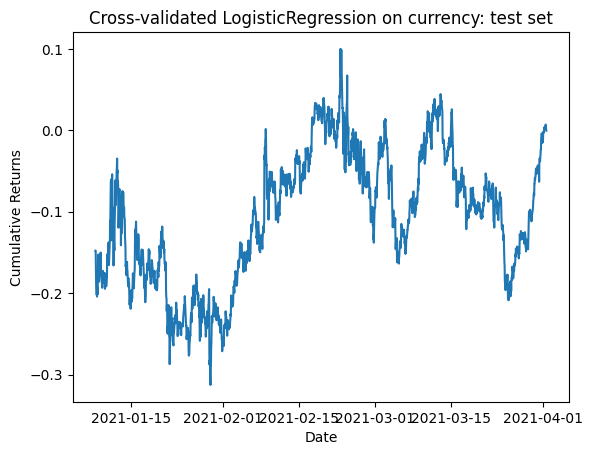

In [ ]:
# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

#dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * x_test.ret1 #for trading at the close
dailyRet2 = pd.Series(positions2).fillna(0).values * df_test['open'].pct_change(1).shift(-1).fillna(0) #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

# plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative"))

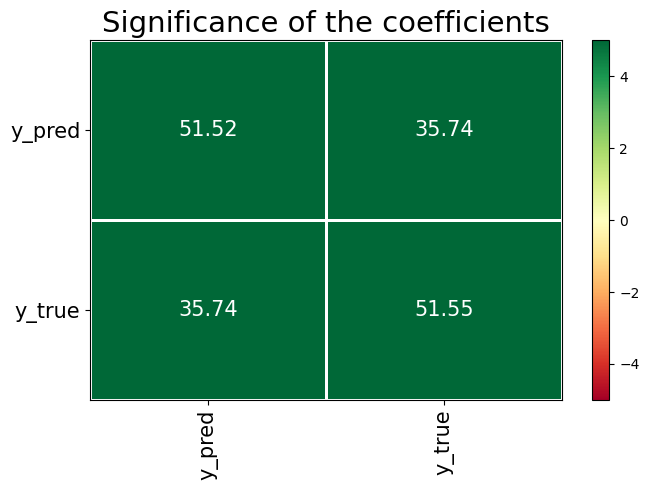

Out-of-sample: CAGR=-0.019944 Sharpe ratio=-0.0234163 maxDD=-0.375108 maxDDD=1086 Calmar ratio=-0.0531686  phi_k_corr=0.930428 phi_k_p_val=0.0  accuracy_score=0.886



In [ ]:
#metrics
accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
plt.show()
# plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accuracy_score))

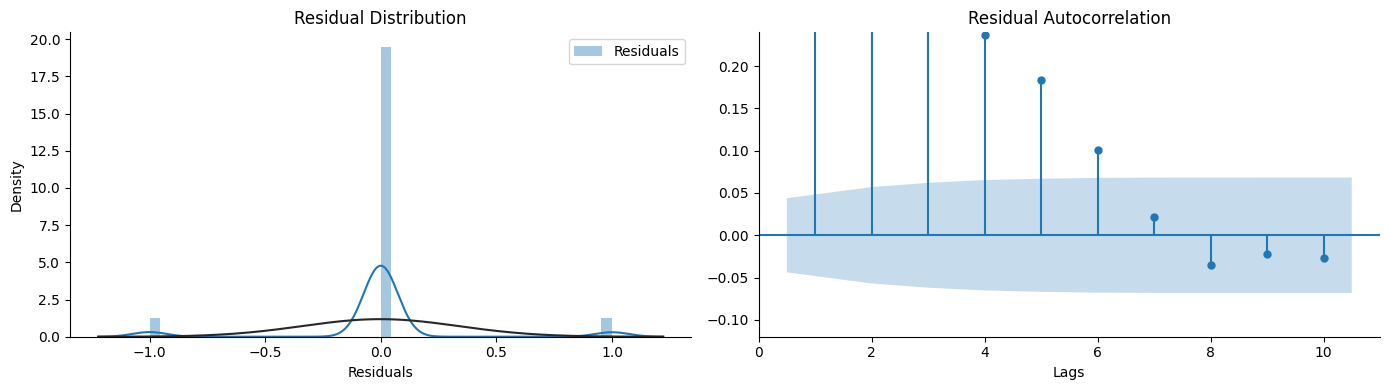

In [ ]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
axes[1].set_ylim(-0.12, 0.24)
sns.despine()
fig.tight_layout();
plt.show()
# plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
# plt.close("all")

Ljung-Box test p-value 9.874388175072979e-301
average return -0.000887
[-0.00193333  0.0018535 ]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.8126


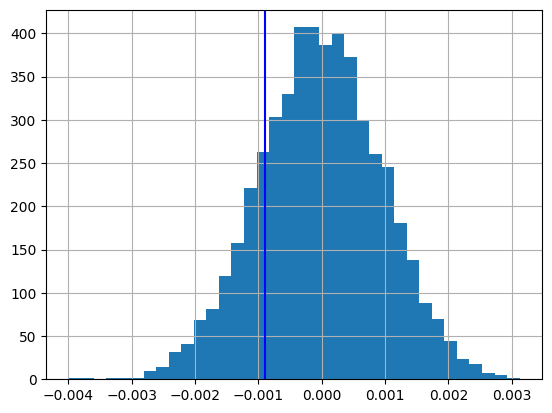

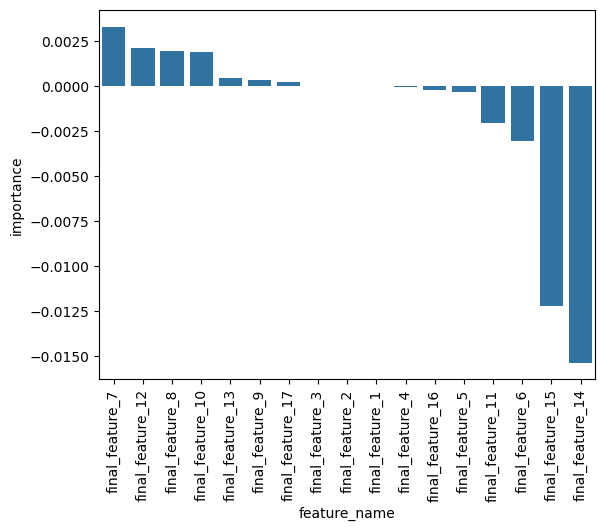

In [ ]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.loc[10, 'lb_pvalue'])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)
plt.show()

# column_names = []
# num_numeric = best_parameters['t5__pca__n_components']
# for i in range(1,num_numeric+1):
#     column_names.append('numeric_features_'+str(i))
# num_dummies = len(best_model[1].coef_.ravel().tolist())-num_numeric
# for i in range(1,num_dummies+1):
#     column_names.append('dummies_'+str(i))

# ##plot the coefficients
# plt.figure(figsize=(10, 10))
# importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
# importance.columns = ['slope','feature_name']
# importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
# for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
#     item.set_rotation(90)
# plt.show()

column_names = []
num_numeric = best_parameters['t5__pca__n_components'] + len(categorical_features_no)
for i in range(1,num_numeric+1):
    column_names.append('final_feature_'+str(i))

importance = pd.DataFrame(zip(grid_search.best_estimator_['logistic'].coef_.ravel().tolist(), column_names))
importance.columns = ['importance','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['importance'], data=importance,orient='v',dodge=False,order=importance.sort_values('importance',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
plt.show()
# plt.savefig(r'Results\%s.png' %("Coefficients"))

**Now, let's use Monte Calo permutation to test the model**

In [ ]:
df = pd.read_csv('BTC-Hourly.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.drop(['unix','symbol'], axis=1)

In [ ]:
df.head()

,date,open,high,low,close,Volume BTC,Volume USD
0,2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#build date-time features
df["hour"] = df['date'].dt.hour
df["day"] = df['date'].dt.dayofweek
df = df.drop(['date'], axis=1)

#buld window features:
# for n in list(range(1,10)):  #use 5 instead of 21 because it takes a long time
#     name = 'ret' + str(n)
#     df[name] = df["open"].pct_change(periods=n) #for trading with open

#new window features
# df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
# lg=3
# df['vratio']=df['ret1'].rolling(100*lg).apply(lambda s: vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build target assuming we know today's open
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
# df['retFut1'] = df['open'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
# df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0) #transform the target
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#Create short simple moving average over the short window
df['short_mavg'] = df['open'].pct_change(periods=10).shift(-1).fillna(0)
#Create long simple moving average over the long window
df['long_mavg'] = df['open'].pct_change(periods=60).shift(-1).fillna(0)
#Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

#Since we are trading right after the open,
#we only know yesterday's  high low close volume etc.
df['high'] = df['high'].shift(1).fillna(0)
df['low'] = df['low'].shift(1).fillna(0)
df['close'] = df['close'].shift(1).fillna(0)
df['Volume BTC'] = df['Volume BTC'].shift(1).fillna(0)
df['Volume USD'] = df['Volume USD'].shift(1).fillna(0)

#Build some Ta-lib features
df['SMA10'] = df['close'].rolling(window=10).mean()
df['SMA30'] = df['close'].rolling(window=30).mean()
df['SMA200'] = df['close'].rolling(window=200).mean()
df['Corr10']= df['close'].rolling(window=10).corr(df['SMA10'])
df['Corr30']= df['close'].rolling(window=30).corr(df['SMA30'])
df['Corr200']= df['close'].rolling(window=200).corr(df['SMA200'])
df['SAR']=ta.SAR(np.array(df['high']),np.array(df['low']), 0.2, 0.2)
df['ADX10']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=10)
df['ADX30']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=30)
df['ADX200']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=200)
df['OO']= df['open']-df['open'].shift(1)
df['OC']= df['open']-df['close']
df.fillna(0, inplace=True)

#Build volume momentum features
# Define the function to compute volume momentum
# def compute_volume_momentum(column):
#   lookback = 10
#   mult = 20
#   raw = np.log(column.rolling(window=lookback).mean()) - np.log(column.rolling(window=lookback*mult).mean())  # raw calculation
#   # volume_momentum = 100 * norm.cdf(3 * raw / np.cbrt(mult)) - 50  # volume momentum
#   return raw

# df['BTC_VM'] = compute_volume_momentum(df['Volume BTC'])
# df['USD_VM'] = compute_volume_momentum(df['Volume USD'])

#Build the same features from the original method
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA10'] = EMA(df, 10)
df['EMA30'] = EMA(df, 30)
df['EMA200'] = EMA(df, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    # Cap extreme values to avoid issues
    M = M.clip(lower=-1e6, upper=1e6)
    N = N.clip(lower=1e-6)  # Ensure no division by zero
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC
df['ROC10'] = ROC(df['close'], 10)
df['ROC30'] = ROC(df['close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM10'] = MOM(df['close'], 10)
df['MOM30'] = MOM(df['close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period])  # First value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period])  # First value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / (d.ewm(com=period-1, adjust=False).mean())
    return 100 - 100 / (1 + rs)
df['RSI10'] = RSI(df['close'], 10)
df['RSI30'] = RSI(df['close'], 30)
df['RSI200'] = RSI(df['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

df['%K10'] = STOK(df['close'], df['low'], df['high'], 10)
df['%D10'] = STOD(df['close'], df['low'], df['high'], 10)
df['%K30'] = STOK(df['close'], df['low'], df['high'], 30)
df['%D30'] = STOD(df['close'], df['low'], df['high'], 30)
df['%K200'] = STOK(df['close'], df['low'], df['high'], 200)
df['%D200'] = STOD(df['close'], df['low'], df['high'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA21'] = MA(df, 10)
df['MA63'] = MA(df, 30)
df['MA252'] = MA(df, 200)

#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig)
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    # print(phi_k_p_val)
    return phi_k_corr

def target_encoder (X, y):
    # use target encoding to encode the categorical features
    x_train_enc = pd.DataFrame(X, columns=x_train.columns)
    y_train_enc = X.join(y).signal
    enc = TargetEncoder(cols=['hour', 'day'])
    # transform the datasets
    x_train_enc = enc.fit_transform(x_train_enc, y_train_enc)
    x_train_enc =x_train_enc.fillna(0)
    return x_train_enc

In [ ]:
# import tensorflow as tf
# # Check GPU availability
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# # Enable GPU support
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
best_cross_val_score_list = []
N = 10 # takes way too long to run, reduce the number of permutations from 100 to 10 (still would take more than 1 hour to run)
#The following Monte Calo permutation is setup so that it preserves the time order
for n in range(0,N):
  # Number of samples to select
  num_samples = 10000
  # Get the indices of all rows
  all_indices = list(df.index)
  # Shuffle the indices randomly
  random.shuffle(all_indices)
  # Sort the shuffled indices based on their original order
  selected_indices = sorted(all_indices[:num_samples])
  # Use the selected indices to extract the corresponding rows from the DataFrame
  df_permu = df.iloc[selected_indices].reset_index(drop=True)

  #save the close and open for white reality check
  # openp = df_permu['open'].copy() #for the case we want to enter trades at the open
  # close = df_permu['close'].copy() #for the case we want to enter trades at the close

  #excluding columns that are not needed for our prediction.
  df_permu_filtered = df_permu.drop(['high','low','close'], axis=1) #optional

  #distribute the df data into X inputs and y target
  # X = df_filtered.drop(['retFut1','retFut1_categ'], axis=1)
  # y = df_filtered[['retFut1_categ']]
  X = df_permu_filtered.drop(['short_mavg','long_mavg','signal'], axis=1)
  y = df_permu_filtered[['signal']]

  #select the samples
  x_train = X.iloc[0:8000]
  x_test = X.iloc[8000:10000]

  y_train = y.iloc[0:8000]
  y_test = y.iloc[8000:10000]

  df_train = df_permu_filtered.iloc[0:8000]
  df_test = df_permu_filtered.iloc[8000:10000]

  myscorer = make_scorer(phi_k, greater_is_better=True)
  # myscorer = None #use default accuracy score

  # numeric_sub_pipeline = Pipeline(steps=[
  #     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
  #     ('scaler', StandardScaler()),
  #     ('pca', PCA())])
  # categorical_sub_pipeline = Pipeline(steps=[
  #     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
  #     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

  targetencoder = FunctionTransformer(target_encoder,kw_args={'y': y_train})

  # print(x_train.dtypes)
  numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
  categorical_features_ix = x_train.select_dtypes(include=['int64','int32']).columns
  all_features_ix = x_train.columns

  # preprocessor = ColumnTransformer(
  #     transformers=[
  #         ('num', numeric_sub_pipeline, numeric_features_ix),
  #         ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

  categorical_features_no = []
  for i in categorical_features_ix:
    categorical_features_no.append(x_train.columns.get_loc(i))

  numeric_features_no = []
  for i in numeric_features_ix:
    numeric_features_no.append(x_train.columns.get_loc(i))

  all_features_no = []
  for i in all_features_ix:
    all_features_no.append(x_train.columns.get_loc(i))

  encoder = ColumnTransformer(transformers=[('target', targetencoder, all_features_no)], remainder='passthrough')
  imputer = ColumnTransformer(transformers=[('imputer', SimpleImputer(strategy='constant', fill_value=0), numeric_features_no)], remainder='passthrough')
  extractor = ColumnTransformer(transformers=[('pca', PCA(), numeric_features_no)], remainder='passthrough')

  #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
  #use logistic regression
  logistic = LogisticRegression(max_iter=1000, solver='liblinear')

  # pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])
  pipe = Pipeline(steps=[('encoder', encoder),('imputer', imputer),('t5', extractor),('logistic', logistic)])

  #Best parameters : {'t5__pca__n_components': 15, 'logistic__penalty': 'l1', 'logistic__C': 0.4832930238571757}
  ncomponents_rs = np.array([15]) # use the optimal result from above
  c_rs = np.array([0.4832930238571757]) # use the optimal result from above
  p_rs= ["l1"] # use the optimal result from above

  # param_grid =  [{'preprocessor__num__pca__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]
  param_grid =  {'t5__pca__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}
  #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
  # #use random forest classifier
  # rfc = RandomForestClassifier(n_jobs=-1)

  # pipe = Pipeline(steps=[('preprocessor', preprocessor),('rfc', rfc)])

  # ncomponents_rs = np.arange(2, 15+1) #from 2 to 15
  # n_estimators_rs = np.array([50,100,200])

  # param_grid =  [{'preprocessor__num__pca__n_components': ncomponents_rs, 'rfc__n_estimators': n_estimators_rs}]
  #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

  grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

  grid_search.fit(x_train, y_train.values.ravel())

  best_parameters = grid_search.best_params_
  best_model = grid_search.best_estimator_

  # print("Best parameters : {}".format(best_parameters))
  # print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
  best_cross_val_score_list.append(grid_search.best_score_*100)

In [ ]:
print(best_cross_val_score_list)

[82.7740559088696, 82.052830819256, 88.78240319242407, 85.69506102587322, 82.95961621840092, 90.23370103007997, 88.30548601862317, 79.15839592798369, 87.35941419200132, 83.3011533786378]


In [ ]:
# Calculate maximum value
max_value = np.max(best_cross_val_score_list)
# Calculate minimum value
min_value = np.min(best_cross_val_score_list)
# Calculate average value
average_value = np.mean(best_cross_val_score_list)
# Calculate standard deviation
std_deviation = np.std(best_cross_val_score_list)

# Print the results
print("Maximum value:", max_value)
print("Minimum value:", min_value)
print("Average value:", average_value)
print("Standard deviation:", std_deviation)

Maximum value: 90.23370103007997
Minimum value: 79.15839592798369
Average value: 85.06221177121498
Standard deviation: 3.36823243773423


#Part 3 - Modified case two (PCA, logestic regression, smoothing, target encoding*)

**Target encoding applied to all features*

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

!pip install phik
!pip install PyWavelets
!pip install category-encoders

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4007    0  4007    0     0  14178      0 --:--:-- --:--:-- --:--:-- 14159
100  517k  100  517k    0     0   721k      0 --:--:-- --:--:-- --:--:--  721k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4067    0  4067    0     0  18420      0 --:--:-- --:--:-- --:--:-- 18486
100  392k  100  392k    0     0   689k      0 --:--:-- --:--:-- --:--:-- 1924k
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
#load BTC-Hourly.csv.zip
from google.colab import files
uploaded = files.upload()

Saving BTC-Hourly.csv.zip to BTC-Hourly.csv.zip


In [ ]:
import zipfile

# Unzip
with zipfile.ZipFile('BTC-Hourly.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
from datetime import *
from numpy import *
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import scipy.io as sio
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
np.random.seed(1) #to fix the results

def normcdf(X):
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    if X < 0:
        w = 1.0-w
    return w

def vratio(a, lag = 2, cor = 'hom'):
    """ the implementation found in the blog Leinenbock
    http://www.leinenbock.com/variance-ratio-test/
    """
    #t = (std((a[lag:]) - (a[1:-lag+1])))**2;
    #b = (std((a[2:]) - (a[1:-1]) ))**2;

    n = len(a)
    mu  = sum(a[1:n]-a[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    #print( mu, m, lag)
    b=sum(square(a[1:n]-a[:n-1]-mu))/(n-1)
    t=sum(square(a[lag:n]-a[:n-lag]-lag*mu))/m
    vratio = t/(lag*b);

    la = float(lag)

    if cor == 'hom':
        varvrt=2*(2*la-1)*(la-1)/(3*la*n)

    elif cor == 'het':
        varvrt=0;
        sum2=sum(square(a[1:n]-a[:n-1]-mu));
        for j in range(lag-1):
            sum1a=square(a[j+1:n]-a[j:n-1]-mu);
            sum1b=square(a[1:n-j]-a[0:n-j-1]-mu)
            sum1=dot(sum1a,sum1b);
            delta=sum1/(sum2**2);
            varvrt=varvrt+((2*(la-j)/la)**2)*delta

    zscore = (vratio - 1) / sqrt(float(varvrt))
    pval = normcdf(zscore);

    return  vratio, zscore, pval

def hurst2(ts):
    """ the implementation found in the blog Leinenbock
    http://www.leinenbock.com/calculation-of-the-hurst-exponent-to-test-for-trend-and-mean-reversion/
    """
    tau = []; lagvec = []
    #  Step through the different lags
    for lag in range(2,100):
        #  produce price difference with lag
        pp = subtract(ts[lag:],ts[:-lag])
        #  Write the different lags into a vector
        lagvec.append(lag)
        #  Calculate the variance of the differnce vector
        tau.append(sqrt(std(pp)))

    #  linear fit to double-log graph (gives power)
    m = polyfit(log10(lagvec),log10(tau),1)
    # calculate hurst
    hurst = m[0]*2.0
    # plot lag vs variance
    #plt.plot(lagvec,tau,'o')
    #plt.show()

    return hurst

def hurst(ts):
    """ the implewmentation on the blog http://www.quantstart.com
    http://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
    Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def half_life(ts):
    """ this function calculate the half life of mean reversion
    """
    # calculate the delta for each observation.
    # delta = p(t) - p(t-1)
    delta_ts = diff(ts)
        # calculate the vector of lagged prices. lag = 1
    # stack up a vector of ones and transpose
    lag_ts = vstack([ts[1:], ones(len(ts[1:]))]).T

    # calculate the slope (beta) of the deltas vs the lagged values
    beta = linalg.lstsq(lag_ts, delta_ts)

    # compute half life
    half_life = log(2) / beta[0]

    return half_life[0]

def random_walk(seed=1000, mu = 0.0, sigma = 1, length=1000):
    """ this function creates a series of independent, identically distributed values
    with the form of a random walk. Where the best prediction of the next value is the present
    value plus some random variable with mean and variance finite
    We distinguish two types of random walks: (1) random walk without drift (i.e., no constant
    or intercept term) and (2) random walk with drift (i.e., a constant term is present).
    The random walk model is an example of what is known in the literature as a unit root process.
    RWM without drift: Yt = Yt−1 + ut
    RWM with drift: Yt = δ + Yt−1 + ut
    """

    ts = []
    for i in range(length):
        if i == 0:
            ts.append(seed)
        else:
            ts.append(mu + ts[i-1] + random.gauss(0, sigma))

    return ts

def subset_dataframe(data, start_date, end_date):
    start = data.index.searchsorted(start_date)
    end = data.index.searchsorted(end_date)
    return data.ix[start:end]

def cointegration_test(y, x):
    ols_result = sm.OLS(y, x).fit()
    return ts.adfuller(ols_result.resid, maxlag=1)


def get_data_from_matlab(file_url, index, columns, data):
    """Description:*
    This function takes a Matlab file .mat and extract some
    information to a pandas data frame. The structure of the mat
    file must be known, as the loadmat function used returns a
    dictionary of arrays and they must be called by the key name

    Args:
        file_url: the ubication of the .mat file
        index: the key for the array of string date-like to be used as index
        for the dataframe
        columns: the key for the array of data to be used as columns in
        the dataframe
        data: the key for the array to be used as data in the dataframe
    Returns:
        Pandas dataframe

    """

    import scipy.io as sio
    import datetime as dt
    # load mat file to dictionary
    mat = sio.loadmat(file_url)
    # define data to import, columns names and index
    cl = mat[data]
    stocks = mat[columns]
    dates = mat[index]

    # extract the ticket to be used as columns name in dataframe
    # to-do: list compression here
    columns = []
    for each_item in stocks:
        for inside_item in each_item:
            for ticket in inside_item:
                columns.append(ticket)
    # extract string ins date array and convert to datetimeindex
    # to-do list compression here
    df_dates =[]
    for each_item in dates:
        for inside_item in each_item:
            df_dates.append(inside_item)
    df_dates = pd.Series([pd.to_datetime(date, format= '%Y%m%d') for date in df_dates], name='date')

    # construct the final dataframe
    data = pd.DataFrame(cl, columns=columns, index=df_dates)

    return data


def my_path(loc):
    if loc == 'PC':
        root_path = 'C:/Users/javgar119/Documents/Python/Data/'
    elif loc == 'MAC':
        root_path = '/Users/Javi/Documents/MarketData/'
    return root_path

# import pandas as pd
from matplotlib import pyplot
import numpy as np
# import statsmodels.api as sm

def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid

#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    ser = np.log(ser+1)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5]))
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break

    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)



    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.axvline(x = ave, color = 'b', label = 'axvline - full height')
   # plt.show()

def backshift(day,x):
    assert day > 0,'Invalid day'
    shift = np.zeros((np.shape(x)))
    shift[day:] = x[:-day]
    shift[shift==0] = np.nan
    return shift

def calculateReturns(prices, lag):
    prevPrices = backshift(lag, prices)
    rlag = (prices - prevPrices) / prevPrices
    return rlag

def fwdshift(day,x):
    assert day > 0,'Invalid day'
    shift = np.zeros((np.shape(x)))
    shift[:-day] = x[day:]
    shift[shift==0] = np.nan
    return shift

def calculateMaxDD(cumret):
    highwatermark = np.zeros(len(cumret))
    drawdown      = np.zeros(len(cumret))
    drawdownduration = np.zeros(len(cumret))
    for t in range(1, len(cumret)):
        highwatermark[t] = np.max([highwatermark[t-1], cumret[t]])
        drawdown[t] = (1+cumret[t]) / (1 + highwatermark[t]) - 1
        if (drawdown[t]==0):
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    return np.min(drawdown), np.max(drawdownduration)

In [ ]:
df = pd.read_csv('BTC-Hourly.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01 00:00:00,1646092800,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,1646089200,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2022-02-28 22:00:00,1646085600,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
2022-02-28 21:00:00,1646082000,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
2022-02-28 20:00:00,1646078400,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
df = df.drop(['unix','symbol'], axis=1)
df.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#save the close and open for white reality check
openp = df['open'].copy() #for the case we want to enter trades at the open
close = df['close'].copy() #for the case we want to enter trades at the close

#build window features:
window_features = []
for n in [10,30,200]:  #use 10, 30, 200
    name = 'ret' + str(n)
    window_features.append(name)
    df[name] = df["open"].pct_change(periods=n) #for trading with open

#new window features
# df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
# lg=3
# df['vratio']=df['ret1'].rolling(100*lg).apply(lambda s: vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
# df['retFut1'] = df['open'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
# df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0) #transform the target
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#Create short simple moving average over the short window
df['short_mavg'] = df['open'].pct_change(periods=10).shift(-1).fillna(0)
#Create long simple moving average over the long window
df['long_mavg'] = df['open'].pct_change(periods=60).shift(-1).fillna(0)
#Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

#Since we are trading right after the open,
#we only know yesterday's  high low close volume etc.
df['high'] = df['high'].shift(1).fillna(0)
df['low'] = df['low'].shift(1).fillna(0)
df['close'] = df['close'].shift(1).fillna(0)
df['Volume BTC'] = df['Volume BTC'].shift(1).fillna(0)
df['Volume USD'] = df['Volume USD'].shift(1).fillna(0)

#Build some Ta-lib features, with n=10, to be optiized in the pipeline
# df['SMA10'] = df['close'].rolling(window=10).mean()
# df['SMA30'] = df['close'].rolling(window=30).mean()
# df['SMA200'] = df['close'].rolling(window=200).mean()
# df['Corr10']= df['close'].rolling(window=10).corr(df['SMA10'])
# df['Corr30']= df['close'].rolling(window=30).corr(df['SMA30'])
# df['Corr200']= df['close'].rolling(window=200).corr(df['SMA200'])
# df['SAR']=ta.SAR(np.array(df['high']),np.array(df['low']), 0.2, 0.2)
# df['ADX10']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=10)
# df['ADX30']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=30)
# df['ADX200']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod=200)
# df['OO']= df['open']-df['open'].shift(1)
# df['OC']= df['open']-df['close']
# df.fillna(0, inplace=True)
n=10
df['RSI']=ta.RSI(np.array(df['close']), timeperiod=n) #can change this to open, but use close for the sake of consistency
df['SMA'] = df['close'].rolling(window=n).mean()
df['Corr']= df['close'].rolling(window=n).corr(df['SMA'])
df['SAR']=ta.SAR(np.array(df['high']),np.array(df['low']), 0.2,0.2)
df['ADX']=ta.ADX(np.array(df['high']),np.array(df['low']), np.array(df['open']), timeperiod =n)
df['OO']= df['open']-df['open'].shift(1)
df['OC']= df['open']-df['close']
df.fillna(0, inplace=True)

#Build volume momentum features
# Define the function to compute volume momentum
# def compute_volume_momentum(column):
#   lookback = 10
#   mult = 20
#   raw = np.log(column.rolling(window=lookback).mean()) - np.log(column.rolling(window=lookback*mult).mean())  # raw calculation
#   # volume_momentum = 100 * norm.cdf(3 * raw / np.cbrt(mult)) - 50  # volume momentum
#   return raw

# df['BTC_VM'] = compute_volume_momentum(df['Volume BTC'])
# df['USD_VM'] = compute_volume_momentum(df['Volume USD'])

#Build the same features from the original method, exclude RSI as it will be optimized through pipeline
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA10'] = EMA(df, 10)
df['EMA30'] = EMA(df, 30)
df['EMA200'] = EMA(df, 200)

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    # Cap extreme values to avoid issues
    M = M.clip(lower=-1e6, upper=1e6)
    N = N.clip(lower=1e-6)  # Ensure no division by zero
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC
df['ROC10'] = ROC(df['close'], 10)
df['ROC30'] = ROC(df['close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM10'] = MOM(df['close'], 10)
df['MOM30'] = MOM(df['close'], 30)

#calculation of relative strength index
# def RSI(series, period):
#     delta = series.diff().dropna()
#     u = delta * 0
#     d = u.copy()
#     u[delta > 0] = delta[delta > 0]
#     d[delta < 0] = -delta[delta < 0]
#     u[u.index[period-1]] = np.mean(u[:period])  # First value is sum of avg gains
#     u = u.drop(u.index[:(period-1)])
#     d[d.index[period-1]] = np.mean(d[:period])  # First value is sum of avg losses
#     d = d.drop(d.index[:(period-1)])
#     rs = u.ewm(com=period-1, adjust=False).mean() / (d.ewm(com=period-1, adjust=False).mean())
#     return 100 - 100 / (1 + rs)
# df['RSI10'] = RSI(df['close'], 10)
# df['RSI30'] = RSI(df['close'], 30)
# df['RSI200'] = RSI(df['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

df['%K10'] = STOK(df['close'], df['low'], df['high'], 10)
df['%D10'] = STOD(df['close'], df['low'], df['high'], 10)
df['%K30'] = STOK(df['close'], df['low'], df['high'], 30)
df['%D30'] = STOD(df['close'], df['low'], df['high'], 30)
df['%K200'] = STOK(df['close'], df['low'], df['high'], 200)
df['%D200'] = STOD(df['close'], df['low'], df['high'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA21'] = MA(df, 10)
df['MA63'] = MA(df, 30)
df['MA252'] = MA(df, 200)

In [ ]:
df.tail()

,open,high,low,close,Volume BTC,Volume USD,ret10,ret30,ret200,hour,...,MOM30,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,,,
2018-05-15 10:00:00,8708.32,8821.19,8740.54,8760.00,2842987.30,324.11,0.017850,0.050993,0.158594,10,...,462.60,85.472115,90.870165,91.515294,94.744275,95.584181,97.289875,8599.322,8398.227000,8254.33045
2018-05-15 09:00:00,8728.49,8865.00,8695.11,8795.90,11101273.74,1260.69,0.023672,0.061215,0.144663,9,...,522.50,85.139785,86.976002,90.967202,92.319027,95.166176,95.972866,8627.702,8415.643667,8260.83340
2018-05-15 08:00:00,8739.00,8754.40,8701.35,8708.32,1593991.98,182.62,0.022543,0.068339,0.133460,8,...,422.52,66.305376,78.972425,79.518687,87.333728,88.052463,92.934273,8642.974,8429.727667,8266.79360
2018-05-15 07:00:00,8740.99,8750.27,8660.53,8728.49,7986062.84,917.79,0.024107,0.044938,0.108278,7,...,503.49,65.664772,72.369978,82.155322,84.213737,88.516316,90.578318,8663.158,8446.510667,8272.30915
2018-05-15 06:00:00,8733.86,8766.00,8721.11,8739.00,2390398.89,273.58,0.025065,0.043098,0.105411,6,...,559.01,68.308265,66.759471,83.529196,81.734402,88.157672,88.242150,8682.424,8465.144333,8277.45405


In [ ]:
#excluding columns that are not needed for our prediction.
df_filtered = df.drop(['close'], axis=1) #optional

#distribute the df data into X inputs and y target
# X = df_filtered.drop(['retFut1','retFut1_categ'], axis=1)
# y = df_filtered[['retFut1_categ']]
X = df_filtered.drop(['short_mavg','long_mavg','signal'], axis=1)
y = df_filtered[['signal']]

#select the samples
x_train = X.iloc[0:8000]
x_test = X.iloc[8000:10000]

y_train = y.iloc[0:8000]
y_test = y.iloc[8000:10000]

df_train = df_filtered.iloc[0:8000]
df_test = df_filtered.iloc[8000:10000]

In [ ]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
import pywt
from sklearn.model_selection import TimeSeriesSplit

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig)
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr

#for optimizing the timeperiod of RSI and ADX
#x is a dataframe because this happens first in the pipeline
def RSI_ADX_optimizer(x, timeperiod=None):
    x = pd.DataFrame(x, columns=['open','high','low','RSI', 'ADX'])
    x['RSI'] =ta.RSI(np.array(x['open']), timeperiod=timeperiod)
    x['ADX'] = ta.ADX(np.array(x['high']),np.array(x['low']), np.array(x['open']), timeperiod=timeperiod)
    x=x.fillna(0)
    return x

def target_encoder (X, y):
    # use target encoding to encode the categorical features
    x_train_enc = pd.DataFrame(X, columns=x_train.columns)
    y_train_enc = X.join(y).signal
    enc = TargetEncoder(cols=['hour', 'day'])
    # transform the datasets
    x_train_enc = enc.fit_transform(x_train_enc, y_train_enc)
    x_train_enc =x_train_enc.fillna(0)
    return x_train_enc

def wavelet_smoother(x_train, scale=None):
        wavelet = "db6"
        x_train = pd.DataFrame(x_train)
        df_wavelets = x_train.copy()

        for i in x_train.columns:
            signal = x_train[i]
            coefficients = pywt.wavedec(signal, wavelet, mode='per')
            coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
            reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
            df_wavelets[i] = reconstructed_signal

        df_wavelets = df_wavelets.fillna(0)
        return df_wavelets

myscorer = make_scorer(phi_k, greater_is_better=True)
# myscorer = None #use default accuracy score

#when using smoother, use TimesSeriesSplit
split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window

# numeric_sub_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler()),
#     ('pca', PCA())])
# categorical_sub_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

rsiadx = FunctionTransformer(RSI_ADX_optimizer)
waveletsmoother = FunctionTransformer(wavelet_smoother)
targetencoder = FunctionTransformer(target_encoder,kw_args={'y': y_train})

print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64','int32']).columns
all_features_ix = x_train.columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_sub_pipeline, numeric_features_ix),
#         ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

talib_features_no = []
for c in ['open', 'high', 'low', 'RSI', 'ADX']:
    talib_features_no.append(x_train.columns.get_loc(c))

window_features_no = []
for c in window_features:
    window_features_no.append(x_train.columns.get_loc(c))

categorical_features_no = []
for i in categorical_features_ix:
    categorical_features_no.append(x_train.columns.get_loc(i))

numeric_features_no = []
for i in numeric_features_ix:
    numeric_features_no.append(x_train.columns.get_loc(i))

all_features_no = []
for i in all_features_ix:
    all_features_no.append(x_train.columns.get_loc(i))

encoder = ColumnTransformer(transformers=[('target', targetencoder, all_features_no)], remainder='passthrough')
talib = ColumnTransformer(transformers=[('rsiadx', rsiadx, talib_features_no)], remainder='passthrough')
imputer = ColumnTransformer(transformers=[('imputer', SimpleImputer(strategy='constant', fill_value=0), numeric_features_no)], remainder='passthrough')
smoother = ColumnTransformer(transformers=[('wav', waveletsmoother, window_features_no)], remainder='passthrough')
extractor = ColumnTransformer(transformers=[('pca', PCA(), numeric_features_no)], remainder='passthrough')

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
#use logistic regression
logistic = LogisticRegression(max_iter=1000, solver='liblinear')

# pipe = Pipeline(steps=[('encoder', encoder),('imputer', imputer),('t5', extractor),('logistic', logistic)])
pipe = Pipeline(steps=[('encoder', encoder),('imputer', imputer),('t3', smoother),('t4', talib),('t5', extractor),('logistic', logistic)])

ncomponents_rs = np.array([2, 5, 10, 15, 20, 25, 30])
c_rs = np.logspace(1, -1, num=10, endpoint = True) #shrink the search space to increase speed
p_rs= ["l1", "l2"] #penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
scales_rs = [{'scale': 0.1}, {'scale': 0.5}]
timeperiod_rs =  [{'timeperiod': 10}, {'timeperiod': 30}, {'timeperiod': 200}]

param_grid =  {'t3__wav__kw_args':  scales_rs, 't4__rsiadx__kw_args': timeperiod_rs, 't5__pca__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#
# #use random forest classifier
# rfc = RandomForestClassifier(n_jobs=-1)

# pipe = Pipeline(steps=[('preprocessor', preprocessor),('rfc', rfc)])

# ncomponents_rs = np.arange(2, 15+1) #from 2 to 15
# n_estimators_rs = np.array([50,100,200])

# param_grid =  [{'preprocessor__num__pca__n_components': ncomponents_rs, 'rfc__n_estimators': n_estimators_rs}]
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters : {}".format(best_parameters))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

# print(results.T)
# results.to_csv("results_logisticreg.csv")

open          float64
high          float64
low           float64
Volume BTC    float64
Volume USD    float64
ret10         float64
ret30         float64
ret200        float64
hour            int32
day             int32
RSI           float64
SMA           float64
Corr          float64
SAR           float64
ADX           float64
OO            float64
OC            float64
EMA10         float64
EMA30         float64
EMA200        float64
ROC10         float64
ROC30         float64
MOM10         float64
MOM30         float64
%K10          float64
%D10          float64
%K30          float64
%D30          float64
%K200         float64
%D200         float64
MA21          float64
MA63          float64
MA252         float64
dtype: object
0.0
0.0
0
0.23438445601726543
0.11676352570705661
0.608251298769138
0
0.24608114706582773
0.0008736552026639144
0.007314269698091014
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0
0.25963516739463033
0.1106149208943612
0.6151360588356121
0
0.258982957203928

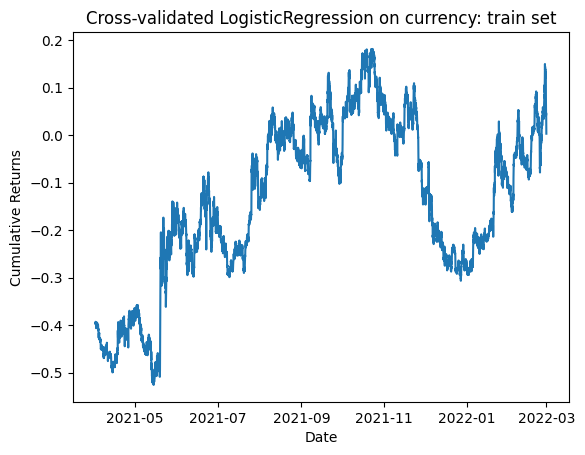

In-sample: CAGR=-0.0157578 Sharpe ratio=-0.0513475 maxDD=-0.598743 maxDDD=4916 Calmar ratio=-0.0263182



In [ ]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
dailyRet = pd.Series(positions).fillna(0).values * df_train['open'].pct_change(1).shift(-1).fillna(0) #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

# plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()
# plt.savefig(r'Results\%s.png' %("TrainCumulative"))

cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

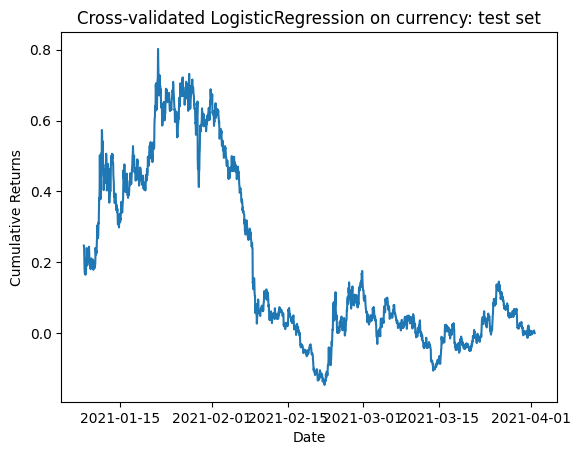

In [ ]:
# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

#dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * x_test.ret1 #for trading at the close
dailyRet2 = pd.Series(positions2).fillna(0).values * df_test['open'].pct_change(1).shift(-1).fillna(0) #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

# plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative"))

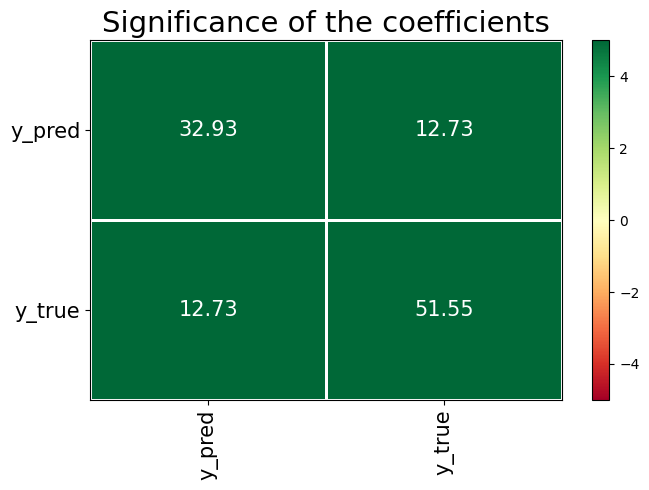

Out-of-sample: CAGR=0.0282071 Sharpe ratio=0.24471 maxDD=-0.353964 maxDDD=604 Calmar ratio=0.0796892  phi_k_corr=0.361416 phi_k_p_val=0.0  accuracy_score=0.4785



In [ ]:
#metrics
accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
plt.show()
# plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accuracy_score))

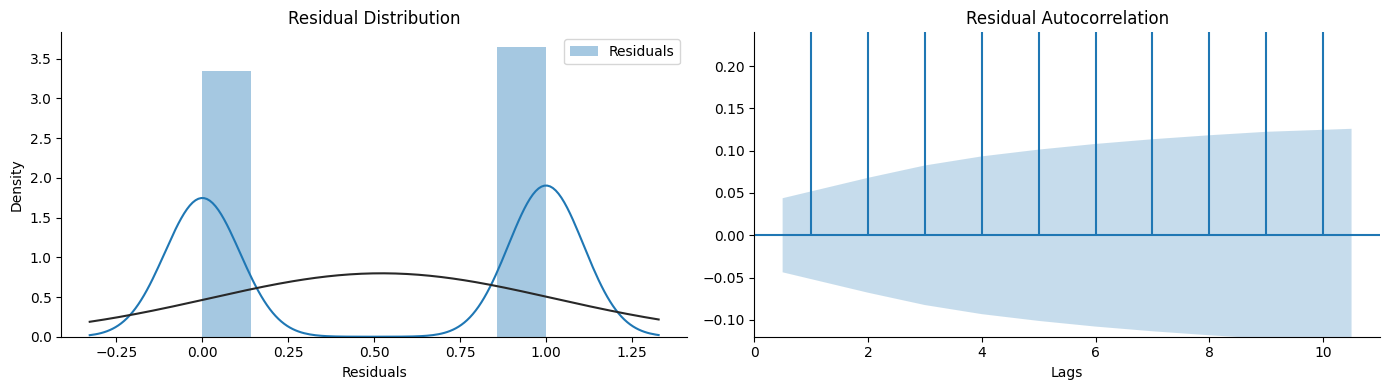

In [ ]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
axes[1].set_ylim(-0.12, 0.24)
sns.despine()
fig.tight_layout();
plt.show()
# plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
# plt.close("all")

Ljung-Box test p-value 0.0
average return -0.001373
[-0.00196598  0.001912  ]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.9172


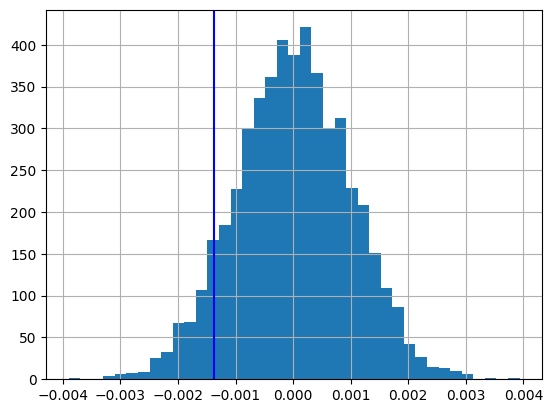

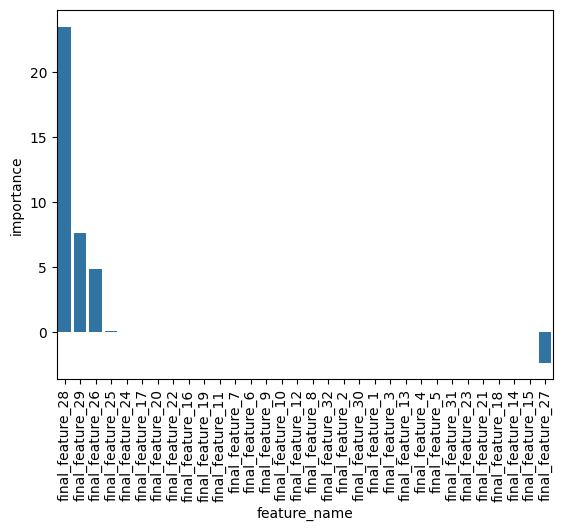

In [ ]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.loc[10, 'lb_pvalue'])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)
plt.show()

column_names = []
num_numeric = best_parameters['t5__pca__n_components'] + len(categorical_features_no)
for i in range(1,num_numeric+1):
    column_names.append('final_feature_'+str(i))

importance = pd.DataFrame(zip(grid_search.best_estimator_['logistic'].coef_.ravel().tolist(), column_names))
importance.columns = ['importance','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['importance'], data=importance,orient='v',dodge=False,order=importance.sort_values('importance',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
plt.show()
# plt.savefig(r'Results\%s.png' %("Coefficients"))

In [ ]:
!pip list > pip_list.txt